In [274]:
# General Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.signal import argrelextrema
from collections import Counter
import re
from collections import defaultdict, Counter
import spacy
import readability

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error


In [275]:
# nltk libraries
import nltk
from nltk.corpus import stopwords, cmudict, opinion_lexicon, words
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('stopwords')
nltk.download('cmudict')
nltk.download('opinion_lexicon')
nltk.download('words')

[nltk_data] Downloading package stopwords to /Users/josh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package cmudict to /Users/josh/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/josh/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package words to /Users/josh/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# Table of Contents
<a id='section-0'> 0. Sentiment Categorization</a>

<a id='section-1'> 1. Base Regression Models (To Predict Sentiment)</a>

<a id='section-2'> 2. Base Classification Models (To Predict Clickbaitiness)</a>

<a id='section-3'> 3. Improving Models Through Data Exploration</a>

<a id='section-4'> 4. Feature Engineering</a>

<div style="background: orange; color: black; padding: 5px">    
    <h5>
        The goal of this project is to train and evaluate predictive models that can classify headline sentiment (positive, neutral, or negative) and detect clickbait using engineered features. Our dataset consists of headlines with corresponding sentiment scores, where the target variable, GPT_score, was categorized into three classes: negative (≤ -0.2), neutral (between -0.2 and 0.4), and positive (≥ 0.4).
    </h5>
    <h5>
        To prepare the data for model training, we implemented feature engineering based on sentiment word analysis. Three lists of sentiment words (negative, neutral, and positive) were manually defined. Additionally, we used the NLTK library to dynamically extract sentiment word lists to enhance our word classification approach. From these lists, we developed several features: flags indicating whether a headline contains negative, neutral, or positive words, counts of such words in the headline, and the density of sentiment words (ratios of sentiment word counts to total word counts).
    </h5>
    <h5>
       We trained multiple models to predict sentiment, including Linear Regression, Decision Tree Regressor, Random Forest Regressor, and Gradient Boosting Regressor. For both Random Forest and Gradient Boosting, we fine-tuned the models using GridSearchCV to optimize hyperparameters. For Random Forest, the hyperparameters tuned were n_estimators and max_depth, while for Gradient Boosting, we tuned n_estimators, learning_rate, and max_depth. 
    </h5>
     <h5>
        Model performance was evaluated using overall accuracy, class-specific accuracy, and mean squared error (MSE) where applicable. For Linear Regression, the baseline model, the overall training accuracy was 55.86%, while the test accuracy was 53.82%. However, a deeper look into the class-specific performance revealed significant imbalances. The model achieved excellent accuracy for the neutral class (~96% on both training and test sets), but performed poorly for the negative class (~25%) and the positive class (~1.7%). This result indicates that the dataset is heavily skewed toward the neutral class, making it challenging for the model to predict minority classes effectively.
    </h5>
    <h5>
        Several challenges were encountered during the project. The most prominent issue was class imbalance, where neutral sentiment dominated the dataset, leading the model to prioritize predicting neutral headlines. To address this, future improvements include implementing oversampling techniques like SMOTE or assigning class weights to the model during training. Additionally, while our manually defined sentiment word lists provided a starting point, the model’s performance suggests that the features could be further improved. Techniques like word embeddings (Word2Vec or BERT), TF-IDF scores, and syntactic features may better capture the sentiment nuances in headlines.
    </h5>
    <h5>
        Linear models like regression assume a linear relationship between features and the target variable, which is likely insufficient for sentiment classification. As a result, using non-linear models such as Random Forest and Gradient Boosting offers greater promise for capturing complex patterns in the data. Evaluation metrics like F1-Score and confusion matrices could further provide deeper insights into the model’s performance across all sentiment classes.
    </h5>
    <h5>
        In conclusion, this project outlines a systematic approach to feature engineering, model training, and evaluation for predicting headline sentiment and clickbait. While the initial models performed ok for the dominant neutral class, significant improvements are required for predicting positive and negative sentiments. Future work will focus on addressing class imbalance, improving feature representation, and exploring advanced machine learning models to enhance overall performance.
    </h5>
</div>

In [276]:
# Reading in the data
df = pd.read_csv('data/nyt_headlines.csv')
print(df.isnull().sum())
df.head()

headline              0
type                  0
year                  0
news_desk_category    0
GPT_score             0
GPT_class             0
dtype: int64


,headline,type,year,news_desk_category,GPT_score,GPT_class
0,Mayflower and Its Vacant Lot to Be Sold,article,2004,home,0.2,balanced
1,Justice Dept. Takeover of Terror Prosecutions ...,article,2001,home,-0.5,balanced
2,Assisted Suicide Can Mask Incompetent Care,article,1997,media,-0.7,clickbait
3,Coach’s Plan to Rouse Ovechkin Produces Little,article,2011,sports,-0.3,clickbait
4,The Retro Experience,multimedia,2010,travel,0.5,clickbait


<h2 id="section-0" style="background: lightblue; color: black; padding: 10px">
    0. Sentiment Categorization
</h2>

<h4 style="background: orange; color: black; padding: 5px">
    We begin by empricially claculating good thresholds for classifying the target outputs, which are in the continous range from -1 to 1, into 3 categories: negative, neutral, and positive.
</h4>

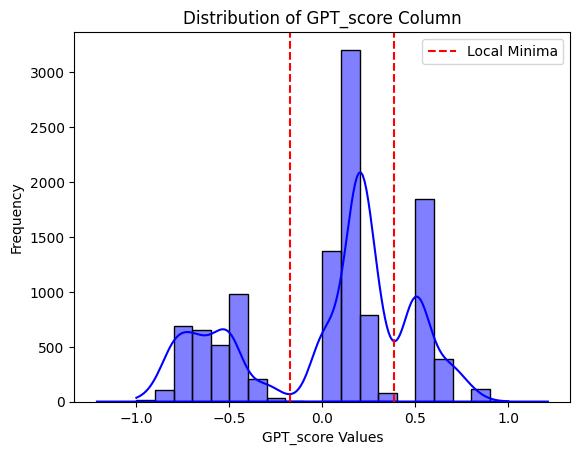

Local Minima: [-0.1758794   0.38693467]


In [277]:
sns.histplot(df['GPT_score'], kde=True, bins=20, color='blue')
plt.title('Distribution of GPT_score Column')
plt.xlabel('GPT_score Values')
plt.ylabel('Frequency')

# Extract kde data
kde = sns.kdeplot(df['GPT_score'], color='blue', fill=False).get_lines()[0]
x, y = kde.get_data()

# Find local minima
minima_indices = argrelextrema(y, np.less)[0]  # Indices of local minima
minima_x = x[minima_indices]

# Plot vertical lines for local minima
for x_min in minima_x[1:]:
    plt.axvline(x=x_min, color='red', linestyle='--', label='Local Minima' if 'Local Minima' not in plt.gca().get_legend_handles_labels()[1] else None)

plt.legend()
plt.show()

print('Local Minima:', minima_x[1:])

<h4 style="background: orange; color: black; padding: 5px">
From our distribution above, we can see some seperation at x = -0.176 and x = 0.387. We'll use these as our cutoffs for classification. Since our chatGPT column values are rounded to the thenths place, we will round our cutoffs to -0.2 and 0.4 accordingly. This means that we will classify anything below -0.2 as negative, anything above 0.4 as positive, and anything in between as neutral. 
</h4>

<h2 style="background: yellow; color: black; padding: 10px" id="section-1">
    1. Base Regression Models (To Predict Sentiment)
</h2>

<div style="background: yellow; color: black; padding: 5px">
    <h4>
        Next, we will attempt to train a base model on our cleaned dataset with some naive modifications. Specifically, we will remove columns that seem irrelevant or unhelpful to us as 'humans evaluators'. In addition, we will add features that we think could add some power to our model's predictions. These features are shown and described below. The columns we remove will include columns like the link to the article (we can't really use these to predict) and the print section this model belongs to. 
    </h4>
    <h4>
        Then, we will use the thresholds we found above to create a new column for sentiment classification which we will use as our target variable.
    </h4>
</div>

In [278]:
# Helper functions to for naive features
def length_of_title(headline):
    features = {
        'char_count': len(headline),
        'word_count': len(headline.split()),
        'avg_word_length': len(headline) / max(len(headline.split()), 1)
    }
    return features

def isExclamation(headline):
    if '!' in headline:
        return 1
    else:
        return 0

def isQuestion(headline):
    if '?' in headline:
        return 1
    else:
        return 0

# Use the Carnegie Mellon Pronouncing Dictionary to get 
# a mapping of words to their pronunciations in the form of phoneme sequences

d = cmudict.dict()

# Use the above to count syllables in a headline
def syllable_count(word):
    word = word.lower()
    if word in d:
        return [len(list(y for y in x if y[-1].isdigit())) for x in d[word]][0]
    else:
        return sum(1 for char in word if char in "aeiou")

sia = SentimentIntensityAnalyzer()

def extract_sentiment_features(headline):
    sentiment = sia.polarity_scores(headline)
    return {
        "pos_score": sentiment['pos'],
        "neg_score": sentiment['neg'],
    }
nlp = spacy.load('en_core_web_sm')

def extract_pos_features(headline):
    doc = nlp(headline)
    pos_counts = {"adj_count": 0, "adv_count": 0}
    for token in doc:
        if token.pos_ == "ADJ":  # Adjectives
            pos_counts["adj_count"] += 1
        elif token.pos_ == "ADV":  # Adverbs
            pos_counts["adv_count"] += 1
    return pos_counts

def calc_readability(headline):
    try:
        text = (headline)
        results = readability.getmeasures(text, lang='en')
        return results['readability grades']['FleschReadingEase']
    except ValueError:
        return 0

In [279]:
# Feature engineering for naive model

df_naive = df.copy()

# length_of_title()
char_counts = []
word_counts = []
avg_word_lengths = []

for headline in df_naive['headline']:
    features = length_of_title(headline)
    char_counts.append(features['char_count'])
    word_counts.append(features['word_count'])
    avg_word_lengths.append(features['avg_word_length'])

df_naive['char_count'] = char_counts
df_naive['word_count'] = word_counts
df_naive['avg_word_length'] = avg_word_lengths

#---------------------------------------------------------#
# isExclamation()
exclamation_marks = []

for headline in df_naive['headline']:
    exclamation_marks.append(isExclamation(headline))

df_naive['has_exclamation'] = exclamation_marks

#---------------------------------------------------------#
# isQuestion()
question_marks = []

for headline in df_naive['headline']:
    question_marks.append(isQuestion(headline))

df_naive['has_question'] = exclamation_marks

#---------------------------------------------------------#
# syllable_count()
syllables = []

for headline in df_naive['headline']:
    syllables.append(syllable_count(headline))

df_naive['syllable count'] = syllables

#---------------------------------------------------------#
# Adjs and Advs
adjs = []
advs = []

for headline in df_naive['headline']:
    features = extract_pos_features(headline)
    adjs.append(features['adj_count'])
    advs.append(features['adv_count'])

df_naive['Adj Count'] = adjs
df_naive['Advs Count'] = advs

#---------------------------------------------------------#
# Readability Score
scores = []
for headline in df_naive['headline']:
    scores.append(calc_readability(headline))
df_naive['Readability Score'] = scores

#---------------------------------------------------------#
# One hot encoding
df_naive = pd.get_dummies(df_naive,
    columns=['type', 'news_desk_category'],
    drop_first=True)

#------------------------- Standardize Distance-Based Models --------------------------------#
# Standardize readability
df_naive_linear = df_naive.copy()
# Select only numerical columns
numerical_columns = df_naive_linear.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = numerical_columns.drop('GPT_score')

# Initialize the scaler
scaler = StandardScaler()

# Scale the numerical columns
df_naive_linear[numerical_columns] = scaler.fit_transform(df_naive_linear[numerical_columns])


<div style="background: Yellow; color: black; padding: 5px">
    <h4>
        Now we should have a dataframe with predictors we can use to train our first models.
    </h4>
</div>

In [280]:
df_naive.head(1)

,headline,year,GPT_score,GPT_class,char_count,word_count,avg_word_length,has_exclamation,has_question,syllable count,...,news_desk_category_special features,news_desk_category_sports,news_desk_category_technology,news_desk_category_theater,news_desk_category_times,news_desk_category_travel,news_desk_category_uncategorized,news_desk_category_weather/environment,news_desk_category_weekend,news_desk_category_world/international/foreign
0,Mayflower and Its Vacant Lot to Be Sold,2004,0.2,balanced,39,8,4.875,0,0,11,...,False,False,False,False,False,False,False,False,False,False


In [281]:
df_naive_linear.head(1)

,headline,year,GPT_score,GPT_class,char_count,word_count,avg_word_length,has_exclamation,has_question,syllable count,...,news_desk_category_special features,news_desk_category_sports,news_desk_category_technology,news_desk_category_theater,news_desk_category_times,news_desk_category_travel,news_desk_category_uncategorized,news_desk_category_weather/environment,news_desk_category_weekend,news_desk_category_world/international/foreign
0,Mayflower and Its Vacant Lot to Be Sold,-0.120827,0.2,balanced,-0.127028,0.388712,-1.085653,-0.056503,-0.056503,-0.310233,...,False,False,False,False,False,False,False,False,False,False


<div style="background: yellow; color: black; padding: 5px">
    <h4>
        Before we train any model, we will take the values from 'GPT_score' to produce a classification column that takes advantage of the threshold we defined that maps our numerical values to a negative, neutral, or positive sentiment.
    </h4>
</div>

In [282]:
# Creating a sentiment column based on the GPT_score for use later
def map_to_sentiment(value):
    if value <= -0.2:
        return 'negative'
    elif value >= 0.4:
        return 'positive'
    else:
        return 'neutral'

df_naive['sentiment'] = df_naive['GPT_score'].apply(map_to_sentiment)
df_naive_linear['sentiment'] = df_naive_linear['GPT_score'].apply(map_to_sentiment)

df_naive.head(1)

,headline,year,GPT_score,GPT_class,char_count,word_count,avg_word_length,has_exclamation,has_question,syllable count,...,news_desk_category_sports,news_desk_category_technology,news_desk_category_theater,news_desk_category_times,news_desk_category_travel,news_desk_category_uncategorized,news_desk_category_weather/environment,news_desk_category_weekend,news_desk_category_world/international/foreign,sentiment
0,Mayflower and Its Vacant Lot to Be Sold,2004,0.2,balanced,39,8,4.875,0,0,11,...,False,False,False,False,False,False,False,False,False,neutral


<h4 style="background: yellow; color: black; padding: 5px">
    Now that we have our workable dataframe, we will now train/fit multiple baseline models based on these naive features and record their accuracy scores to get an initial comparison with the true models. We will use three different regression models we learned in class in a linear regression model, a decision tree, and a random forest. These regression predictions will then be mapped based on the data exploration thresholds we find in our data exploration later on. 
</h4>

In [283]:
X = df_naive_linear.drop(columns=['headline', 'GPT_score', 'sentiment', 'GPT_class'])
y = df_naive_linear['GPT_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)

# Convert GPT_scores to sentiment categories for accuracy scores
y_train_categories = pd.Series(y_train).apply(map_to_sentiment)
y_test_categories = pd.Series(y_test).apply(map_to_sentiment)

In [284]:
# Linear Regression Model
lreg = LinearRegression()

lreg.fit(X_train, y_train)

# --------- Predicting On Training Data --------- #
y_pred_train = lreg.predict(X_train)

# Convert predictions to categories using map_to_sentiment
y_pred_categories = pd.Series(y_pred_train).apply(map_to_sentiment)

# Calculate accuracy
train_accuracy = accuracy_score(y_train_categories, y_pred_categories)
print('Train Accuracy:', train_accuracy)

# --------- Predicting On Testing Data --------- #
y_pred_test = lreg.predict(X_test)

# Convert predictions to categories using map_to_sentiment
y_pred_categories = pd.Series(y_pred_test).apply(map_to_sentiment)

# Caluculate accuracy
test_accuracy = accuracy_score(y_test_categories, y_pred_categories)
print('Test Accuracy:', test_accuracy)


Train Accuracy: 0.535235280745624
Test Accuracy: 0.5404545454545454


In [285]:
# Linear Regression with Lasso Regularization
lasso = LassoCV(cv=5, random_state=109)

lasso.fit(X_train, y_train)

# --------- Predicting On Training Data --------- #
y_pred_train = lasso.predict(X_train)

# Convert predictions to categories using map_to_sentiment
y_pred_categories = pd.Series(y_pred_train).apply(map_to_sentiment)

# Caluculate accuracy
train_accuracy = accuracy_score(y_train_categories, y_pred_categories)
print('Train Accuracy:', train_accuracy)

# --------- Predicting On Testing Data --------- #
y_pred_test = lasso.predict(X_test)

# Convert predictions to categories using map_to_sentiment
y_pred_categories = pd.Series(y_pred_test).apply(map_to_sentiment)

# Caluculate accuracy
test_accuracy = accuracy_score(y_test_categories, y_pred_categories)
print('Test Accuracy:', test_accuracy)

Train Accuracy: 0.5348942941577631
Test Accuracy: 0.54


<h4 style="background: yellow; color: black; padding: 5px">
    Above, we fit two baseline models based on Linear Regression. One fitting a naive Linear Regression on all our models and one where we tried to take advantage of LASSO regularization. However, when calculating the accuracy scores, we notice that that both train/test accuriacies are not that high. LASSO regularization did not seem to help as much, which prompted us to go with another Regression model, the decision tree.
</h4>

In [286]:
X = df_naive.drop(columns=['headline', 'GPT_score', 'sentiment', 'GPT_class'])
y = df_naive['GPT_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)

# Convert GPT_scores to sentiment categories for accuracy scores
y_train_categories = pd.Series(y_train).apply(map_to_sentiment)
y_test_categories = pd.Series(y_test).apply(map_to_sentiment)

In [287]:
# Finding the best parameters for a Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=109)

param_grid = {
    'max_depth': range(2, 15)
}

grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv=5,                              
    n_jobs=-1,                         
    verbose=1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
Best Parameters: {'max_depth': 5}


In [288]:
# Fit the model with the best parameters (depth 5)
dt = DecisionTreeRegressor(random_state=109, max_depth=best_params['max_depth'])

dt.fit(X_train, y_train)

# --------- Predicting On Training Data --------- #
y_pred_train = dt.predict(X_train)

# Convert predictions to categories using map_to_sentiment
y_pred_categories = pd.Series(y_pred_train).apply(map_to_sentiment)

# Caluculate accuracy
train_accuracy = accuracy_score(y_train_categories, y_pred_categories)
print('Train Accuracy:', train_accuracy)

# --------- Predicting On Testing Data --------- #
y_pred_test = dt.predict(X_test)

# Convert predictions to categories using map_to_sentiment
y_pred_categories = pd.Series(y_pred_test).apply(map_to_sentiment)

# Caluculate accuracy
test_accuracy = accuracy_score(y_test_categories, y_pred_categories)
print('Test Accuracy:', test_accuracy)

Train Accuracy: 0.5462605137531257
Test Accuracy: 0.5522727272727272


<h4 style="background: orange; color: black; padding: 5px">
    
Above, we were able to finetune and fit a really good decision tree regressor and improve our accuracy scores. This motivates us to do our last baseline model, the Random Forest, as it would ideally combine many finetuned trees and improve the accuracy score a lot more. We try this below. /h4>AB

In [289]:
# Finding the best parameters for a Random Forest Regressor
rf = RandomForestRegressor(random_state=109)

param_grid = {
    'n_estimators': [250, 300, 350],
    'max_depth': range(6, 12)
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv=5,                              
    n_jobs=-1,                         
    verbose=1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'max_depth': 8, 'n_estimators': 300}


In [290]:
# Fit the model with the best parameters (depth 8, n_estimators 200)
rf = RandomForestRegressor(random_state=109, max_depth=best_params['max_depth'], n_estimators=best_params['n_estimators'])

rf.fit(X_train, y_train)

# --------- Predicting On Training Data --------- #
y_pred_train = rf.predict(X_train)

# Convert predictions to categories using map_to_sentiment
y_pred_categories = pd.Series(y_pred_train).apply(map_to_sentiment)

# Caluculate accuracy
train_accuracy = accuracy_score(y_train_categories, y_pred_categories)
print('Train Accuracy:', train_accuracy)

# --------- Predicting On Testing Data --------- #
y_pred_test = rf.predict(X_test)

# Convert predictions to categories using map_to_sentiment
y_pred_categories = pd.Series(y_pred_test).apply(map_to_sentiment)

# Caluculate accuracy
test_accuracy = accuracy_score(y_test_categories, y_pred_categories)
print('Test Accuracy:', test_accuracy)

Train Accuracy: 0.5700159127074335
Test Accuracy: 0.5545454545454546


<h2 style="background: lightblue; color: black; padding: 10px" id="section-2">
    2. Base Classification Models (To Predict Clickbaitiness)
</h2>

<h4 style="background: orange; color: black; padding: 5px">
    Next we will attempt to train some naive classification modles to predict on the clickbaitiness column 'GPT_class'. For this we will train a Logistic Regression, Decision Tree, and a Random Forest model. We begin with a Logistic Regression model.
</h4>

In [291]:
X = df_naive_linear.drop(columns=['headline', 'GPT_score', 'sentiment', 'GPT_class'])
y = df_naive_linear['GPT_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)

In [292]:
# Train a Logistic Regression model to predict Clickbaitiness
logreg = LogisticRegression(random_state=109, max_iter=1000)

logreg.fit(X_train, y_train)

# --------- Predicting On Training Data --------- #
y_pred_train = logreg.predict(X_train)

# Caluculate accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print('Train Accuracy:', train_accuracy)

# --------- Predicting On Testing Data --------- #
y_pred_test = logreg.predict(X_test)

# Caluculate accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print('Test Accuracy:', test_accuracy)

Train Accuracy: 0.6150261423050694
Test Accuracy: 0.6177272727272727


<h2 style="background: lightblue; color: black; padding: 10px" id="section-3">
    3. Improving Models Through Data Exploration
</h2>

<h5 style="background: orange; color: black; padding: 5px">
Next, we want to visualize the frequency of words in the titles from out datset. We do this by plotting the frequency of all the words that appear in our data from most frequent to least frequent. We use a different csv file called rand_headlines_11k.csv which contains the headlines, but each row directly corresponds to the rows in our data_w_gpt.csv file.
</h5>

In [293]:
# Ensure all values in the 'headline' column are strings and lowercase
df['headline'] = df['headline'].astype(str).str.lower()

# Focus on first 5k rows for EDA for now
pd.options.mode.chained_assignment = None # Disable SettingWithCopyWarning warnings
df_5k = df.head(5000)

df_5k

,headline,type,year,news_desk_category,GPT_score,GPT_class
0,mayflower and its vacant lot to be sold,article,2004,home,0.2,balanced
1,justice dept. takeover of terror prosecutions ...,article,2001,home,-0.5,balanced
2,assisted suicide can mask incompetent care,article,1997,media,-0.7,clickbait
3,coach’s plan to rouse ovechkin produces little,article,2011,sports,-0.3,clickbait
4,the retro experience,multimedia,2010,travel,0.5,clickbait
...,...,...,...,...,...,...
4995,"kate zukerman, blake boshnack",article,2017,social/society,0.0,balanced
4996,"francs, fear and folly",article,2015,opinion/editorial,0.2,clickbait
4997,springsteen says no to christie and yes to sam...,article,2009,entertainment,0.6,clickbait
4998,essay; an unorthodox election,article,1999,media,0.1,clickbait


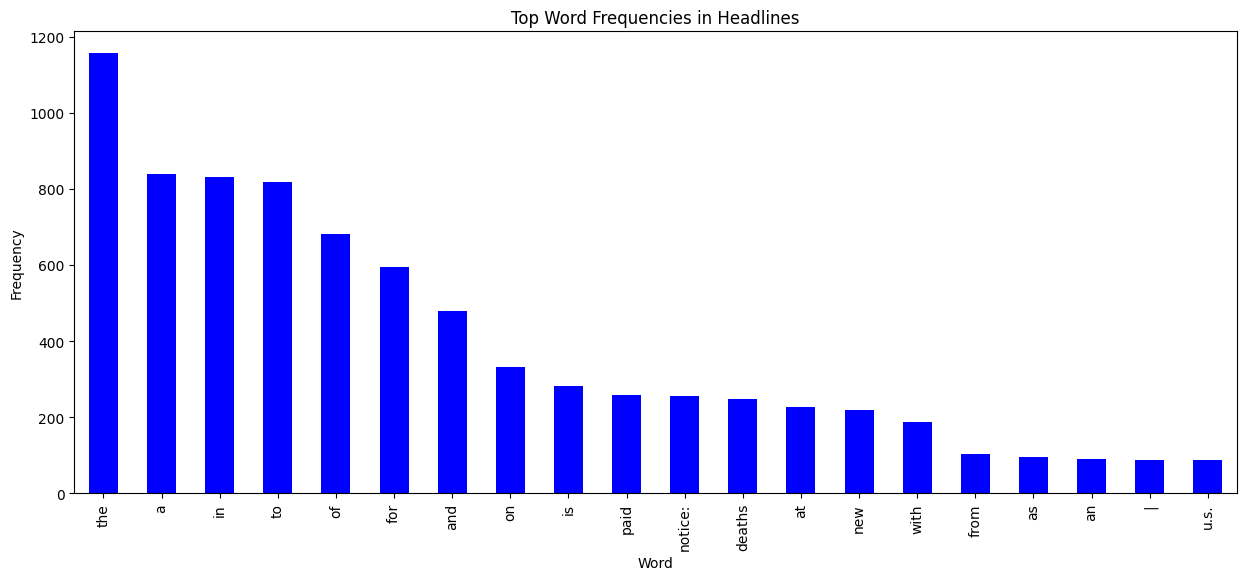

In [294]:
word_counts = Counter(" ".join(df_5k['headline']).split())

# Convert to DataFrame for visualization
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plot the top 40 most frequent words
top_n = 20

word_freq_df.head(top_n).plot.bar(x='Word', y='Frequency', color='blue', legend=False, figsize=(15, 6))  # Also ensure figsize is passed here
plt.title('Top Word Frequencies in Headlines')
plt.ylabel('Frequency')
plt.xlabel('Word')
plt.show()

<h4 style="background: orange; color: black; padding: 5px">
This is a start, but we must notice that there are a lot of stop words that take over. We fix this by removing them using nltk stopwords and plotting words that will be more relevant to our goals for this section. 
</h4>

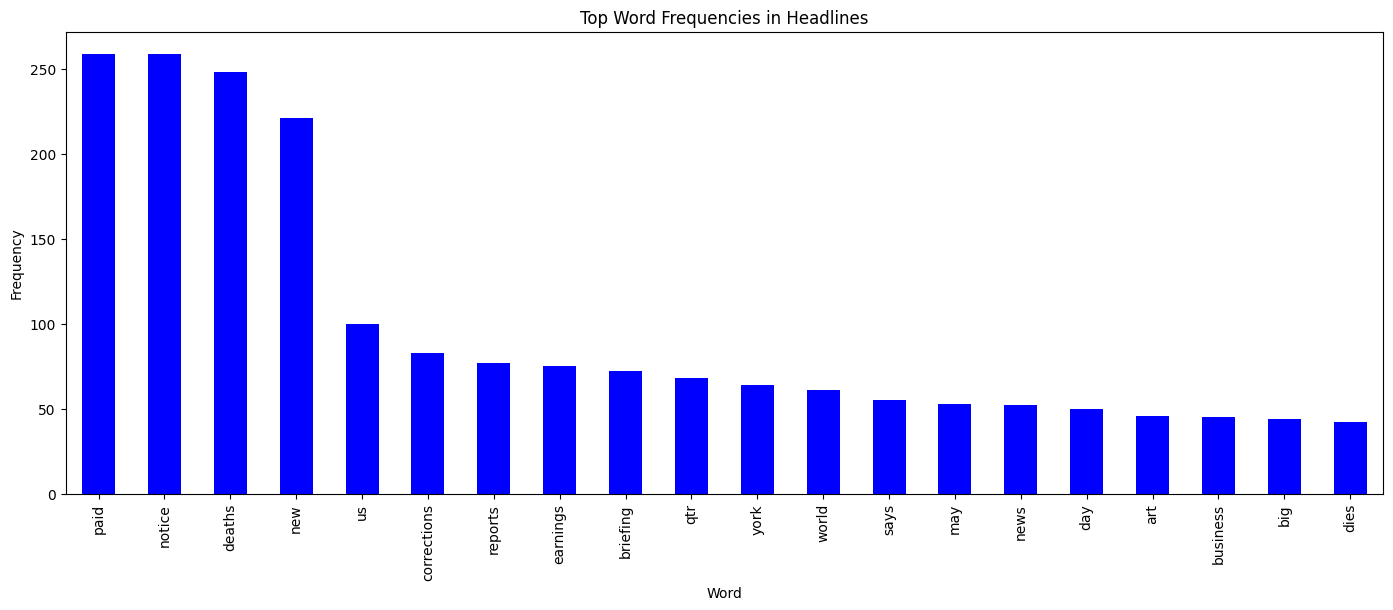

In [295]:
stop_words = set(word.lower() for word in stopwords.words('english')) | {'1', '2', '3', '5', '31', '30'}

# Remove stop words from the 'headline' column
# First 5k
df_5k['headline_no_stopwords'] = df_5k['headline'].apply(
    lambda x: " ".join([
        re.sub(r'[^\w\s]', '', word).strip().lower()  # Remove punctuation and lowercase first
        for word in x.split()
        if re.sub(r'[^\w\s]', '', word).lower() not in stop_words  # Check against stop words
    ])
)

# Next 6k
test_set = df.iloc[5000: 11000]
test_set['headline_no_stopwords'] = test_set['headline'].apply(
    lambda x: " ".join([
        re.sub(r'[^\w\s]', '', word).strip().lower()  # Remove punctuation and lowercase first
        for word in x.split()
        if re.sub(r'[^\w\s]', '', word).lower() not in stop_words  # Check against stop words
    ])
)


# Plot new word frequencies w/o stop words
word_counts = Counter(" ".join(df_5k['headline_no_stopwords']).split())

# Convert to DataFrame for visualization
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plot the top 40 most frequent words
top_n = 20

word_freq_df.head(top_n).plot.bar(x='Word', y='Frequency', color='blue', legend=False, figsize=(17, 6))  # Also ensure figsize is passed here
plt.title('Top Word Frequencies in Headlines')
plt.ylabel('Frequency')
plt.xlabel('Word')
plt.show()

<h4 style="background: orange; color: black; padding: 5px">
This looks a lot better! We got rid of stop words, punctuation, and single numbers that would not be useful to use for further analysis.
</h4>

<h4 style="background: orange; color: black; padding: 5px">
Next, we want to visualize how positive, negative, or neutral each word is by calculating the number of times that word appears in headlines measured as each of these categories by our chatGPT column using the thresholds we decided upon earlier in this notebook.
</h4>

In [296]:
# Classify each value in the 'chatGPT' column
def classify_sentiment(value):
    if value <= -0.2:
        return 'negative'
    elif value >= 0.4:
        return 'positive'
    else:
        return 'neutral'
    
# Apply the classification to a new column
df_5k['sentiment_class'] = df_5k['GPT_score'].apply(classify_sentiment)  
test_set['sentiment_class'] = test_set['GPT_score'].apply(classify_sentiment)  

word_counts_by_sentiment = defaultdict(Counter)

# Tokenize words and count occurrences by sentiment
for _, row in df_5k.iterrows():
    sentiment = row['sentiment_class']
    words = row['headline_no_stopwords'].split()
    word_counts_by_sentiment[sentiment].update(words)
    
for _, row in test_set.iterrows():
    sentiment = row['sentiment_class']
    words = row['headline_no_stopwords'].split()
    word_counts_by_sentiment[sentiment].update(words)

# Convert the sentiment counts to a DataFrame
word_counts_df = pd.DataFrame.from_dict(word_counts_by_sentiment, orient='index').fillna(0).astype(int).T
word_counts_df = word_counts_df[['negative', 'neutral', 'positive']]  # Ensure consistent column order

# Add a total frequency column to sort the words
word_counts_df['total'] = word_counts_df.sum(axis=1)
word_counts_df = word_counts_df.sort_values(by='total', ascending=False)

# Drop the total column (optional, for visualization purposes)
word_counts_df = word_counts_df.drop(columns='total')

'''
Helper functions above
'''
    
# Function plots frequency of words in order of frequency. Colors denote the 
# frequency of headlines containing that word, classified by the function above. 
def plt_word_counts_sentiments(lower, upper, df):
    # Plot the stacked bar chart
    df.iloc[lower:upper].plot(
        kind='bar',
        stacked=True,
        figsize=(15, 8),
        color={'negative': 'red', 'neutral': 'gray', 'positive': 'green'}
    )

    # Customize the chart
    plt.title('Word Sentiment Classification in Headlines')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.legend(title='Sentiment')
    plt.tight_layout()
    plt.show()

In [297]:
# Classify each value in the 'chatGPT' column
def classify_sentiment(value):
    if value <= -0.2:
        return 'negative'
    elif value >= 0.4:
        return 'positive'
    else:
        return 'neutral'
    
# Apply the classification to a new column
df_5k['sentiment_class'] = df_5k['GPT_score'].apply(classify_sentiment)  
test_set['sentiment_class'] = test_set['GPT_score'].apply(classify_sentiment)  

word_counts_by_sentiment = defaultdict(Counter)
word_counts_by_clickbait = defaultdict(Counter)

# Tokenize words and count occurrences by sentiment
for _, row in df_5k.iterrows():
    sentiment = row['sentiment_class']
    words = row['headline_no_stopwords'].split()
    GPT_class = row['GPT_class']
    word_counts_by_sentiment[sentiment].update(words)
    word_counts_by_clickbait[GPT_class].update(words)
    
for _, row in test_set.iterrows():
    sentiment = row['sentiment_class']
    words = row['headline_no_stopwords'].split()
    GPT_class = row['GPT_class']
    word_counts_by_sentiment[sentiment].update(words)
    word_counts_by_clickbait[GPT_class].update(words)

# Convert the sentiment counts to a DataFrame
word_counts_df = pd.DataFrame.from_dict(word_counts_by_sentiment, orient='index').fillna(0).astype(int).T
word_counts_df_clickbait = pd.DataFrame.from_dict(word_counts_by_clickbait, orient='index').fillna(0).astype(int).T

word_counts_df = word_counts_df[['negative', 'neutral', 'positive']]  # Ensure consistent column order
word_counts_df_clickbait = word_counts_df_clickbait[['clickbait', 'balanced', 'matter-of-fact']]  # Ensure consistent column order

# Add a total frequency column to sort the words
word_counts_df['total'] = word_counts_df.sum(axis=1)
word_counts_df = word_counts_df.sort_values(by='total', ascending=False)

# Drop the total column (optional, for visualization purposes)
word_counts_df = word_counts_df.drop(columns='total')

# Same process but for this dataframe
word_counts_df_clickbait['total'] = word_counts_df_clickbait.sum(axis=1)
word_counts_df_clickbait = word_counts_df_clickbait.sort_values(by='total', ascending=False)
word_counts_df_clickbait = word_counts_df_clickbait.drop(columns='total')

'''
Helper functions above
'''
    
# Function plots frequency of words in order of frequency. Colors denote the 
# frequency of headlines containing that word, classified by the function above. 
def plt_word_counts_sentiments(lower, upper, df):
    # Plot the stacked bar chart
    df.iloc[lower:upper].plot(
        kind='bar',
        stacked=True,
        figsize=(15, 8),
        color={'negative': 'red', 'neutral': 'gray', 'positive': 'green'}
    )

    # Customize the chart
    plt.title('Word Sentiment Classification in Headlines')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.legend(title='Sentiment')
    plt.tight_layout()
    plt.show()
    
def plt_word_counts_clickbait(lower, upper, df):
    # Plot the stacked bar chart
    df.iloc[lower:upper].plot(
        kind='bar',
        stacked=True,
        figsize=(15, 8),
        color={'clickbait': 'red', 'balanced': 'gray', 'matter-of-fact': 'green'}
    )

    # Customize the chart
    plt.title('Word Sentiment Classification in Headlines')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.legend(title='Sentiment')
    plt.tight_layout()
    plt.show()
    
sentiments = ['negative', 'neutral', 'positive']
    
def calc_sentiment_proportion(sentiment, lower, upper, threshold, df):
    # Error handling
    if sentiment not in sentiments:
        print('Error: Must enter in "Negative", "Neutral", "Positive" as first argument.')
        
    interval_df = df.iloc[lower:upper]
    interval_df = interval_df[
        (interval_df[sentiment] > (interval_df['negative'] + interval_df['neutral'] + interval_df['positive']) * threshold)
    ]
    return interval_df


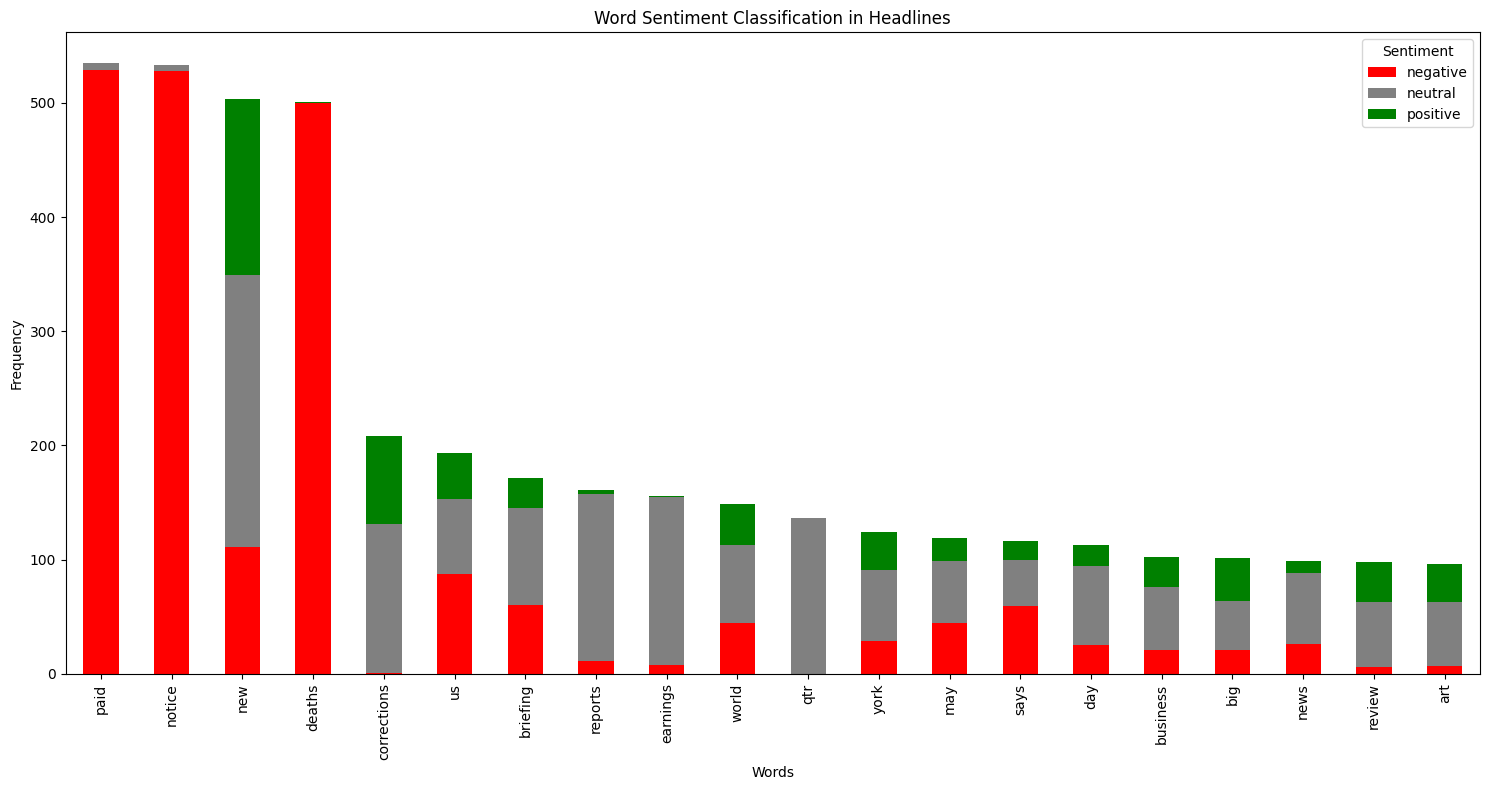

In [298]:
plt_word_counts_sentiments(0, 20, word_counts_df)

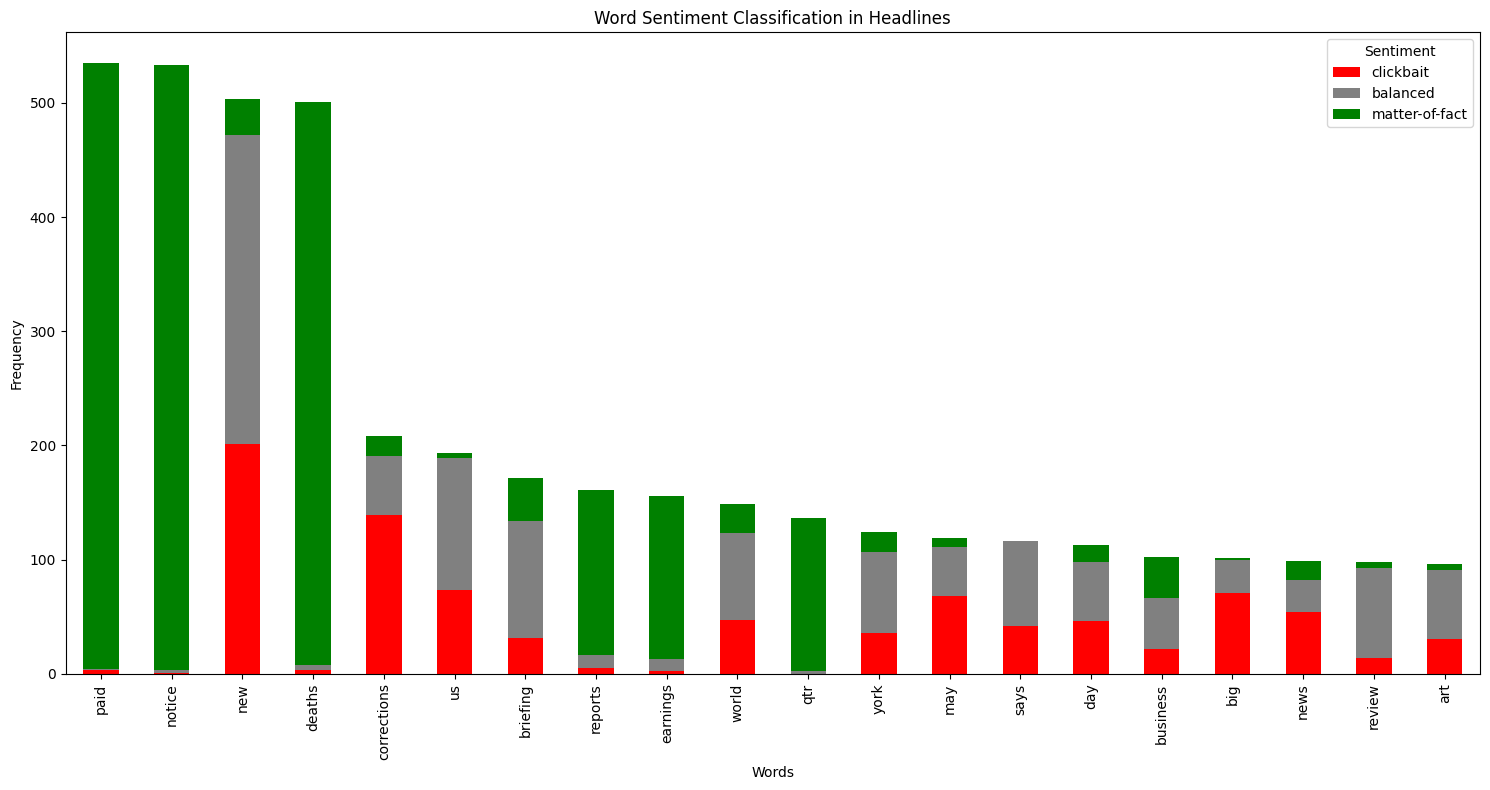

In [299]:
plt_word_counts_clickbait(0, 20, word_counts_df_clickbait)

<h5 style="background: orange; color: black; padding: 5px">
    Now we have a better idea of what words we can use as "features" to help our model better classify headlines!
</h5>

<h5 style="background: orange; color: black; padding: 5px">
    Below we implement an extra function to help with EDA. get_rand_articles() fetches a random subset of the headlines from our dataset of size k based on a given keyword. For example, if we give the function the keyword 'war', we get articles that contian that word. This will help us get a better idea of what kind of headlines use certain words and will be useful for feature engineering later on. 
</h5>

In [300]:
def get_rand_articles(keyword, k, df):
    year_headlines = df[
        df['headline'].str.contains(keyword, case=False, na=False)
    ]['headline']
    print(f'There are {len(year_headlines)} headlines with the word {keyword} in it.')
    print(f'Here are {k} many of those articles randomly sampled: \n')
    n = len(year_headlines)
    if len(year_headlines) < k:
        print(f'There are only {n} available articles.')
        return year_headlines.sample(n=n).tolist()
    return year_headlines.sample(n=k).tolist()

In [301]:
# Example use case with the top word from our sentiment classification above
articles = get_rand_articles('paid', 10, df)
for article in articles:
    print(article)

There are 537 headlines with the word paid in it.
Here are 10 many of those articles randomly sampled: 

paid notice: deaths   pujol, bianca a.
paid notice: deaths  pliskin, david
paid notice: deaths  berkman, alice barrasch.
paid notice: deaths  grubert, margaret alicia (nee johnston)
paid notice: deaths   wolf, semon ii.
paid notice: deaths  pile, sterling jr.
paid notice: deaths  fried, lenore
paid notice: memorials  powell, ann b.
paid notice: deaths  spiegel, daniel
paid notice: deaths   kempner, nan s.


<h5 style="background: orange; color: black; padding: 5px">
    From the example above, we notice that there are many headlines that start with 'paid notice: deaths' which explains why the words 'paid', 'notice', and 'deaths' are classified as very negative in our chart above. This is an intresting finding. 
</h5>

<h2 style="background: lightblue; color: black; padding: 10px" id="section-4">
    4. Feature Engineering
</h2>

<h5 style="background: orange; color: black; padding: 5px">
    Now that we have a better idea of what our data looks like, we can engineer features that are more predictive of a headline's sentiment. To do this, we create a helper function that takes the processed data from above and finds words in the range (lower, upper) that meet a specified threshold of apperance in our data in terms of sentiment classification. For example, we can request the top 150 words that have a 'positive' sentiment 50% of the time (i.e. are classified as positive in 50% or more of the articles the word appears in). We show this example and its output below. 
</h5>

In [302]:
sentiments = ['negative', 'neutral', 'positive']

def calc_sentiment_proportion(sentiment, lower, upper, threshold, df):
    # Error handling
    if sentiment not in sentiments:
        print('Error: Must enter in "Negative", "Neutral", "Positive" as first argument.')
        
    interval_df = df.iloc[lower:upper]
    interval_df = interval_df[
        (interval_df[sentiment] > (interval_df['negative'] + interval_df['neutral'] + interval_df['positive']) * threshold)
    ]
    return interval_df

<div style="background: orange; color: black; padding: 5px">
    <h5>
        The function below allows searches for words that are positive, neutral, or negative a certain percentage of the times its used. The query below contains the inputs 'positive', 0, 150, 0.5, and the word_count_df dataframe. This means we are searching the range from the top 0 to top 150 words in word_counts_df, for words in which more than 50% percent of the time they are used are positive. 
    </h5>
    <h5>
        By looking at the outputs of this function, we are able to put together a list of negative, neutral, and positive words. We used the threshold of 0.5 for negative and neutral words, and from there only selected words that made sense using our own domain knowledge as English speakers. We also noticed that is it harder to find positive words, so we lowered the threshold to 0.4 when selecting positive words, just so there would be more options.
    </h5>
</div>


In [303]:
calc_sentiment_proportion('positive', 0, 150, 0.5, word_counts_df)

,negative,neutral,positive
million,16,12,38
music,3,19,40
wins,1,12,30
love,3,13,19


<div style="background: orange; color: black; padding: 5px">
    <h5>
        The following function is a helper function that takes in as input a model to train in the form of a string and a test and train dataframe. The function then trains the corresponding regression model by minimizng the MSE and outputs an accuracy score by using the thresholds we found at the very beginning of this project (-0.2 and 0.4) to classify the outputs by the model. It also outputs the accuracy scores for each snetiment category to help us better understand the performances of our models. 
    </h5>
</div>

In [304]:
# Run a fine tuned linear regression model with our engineered features
train_accuracies = []
test_accuracies = []

def fit_regressors(model_type, train_df, test_df):
    X_train = train_df.drop(columns=['GPT_score'])
    y_train = train_df['GPT_score']

    X_test = test_df.drop(columns=['GPT_score'])
    y_test = test_df['GPT_score']

    y_train_categories = pd.Series(y_train).apply(map_to_sentiment)
    y_test_categories = pd.Series(y_test).apply(map_to_sentiment)


    match model_type:
        case 'linear':
            model = LinearRegression()
        case 'decision_tree':
            model = DecisionTreeRegressor()
        case 'random_forest':
            # Finding the best parameters for a Random Forest Regressor
            rf = RandomForestRegressor(random_state=109)

            param_grid = {
                'n_estimators': [115, 125, 150],
                'max_depth': range(11, 13)
            }

            grid_search = GridSearchCV(
                estimator=rf,
                param_grid=param_grid,
                scoring='neg_mean_squared_error',  
                cv=5,                              
                n_jobs=-1,                         
                verbose=1
            )

            grid_search.fit(X_train, y_train)

            best_params = grid_search.best_params_
            print("Best Parameters:", best_params)
            print("Best Score:", grid_search.best_score_)
            
            # Fit the model with the best parameters
            model = RandomForestRegressor(random_state=109, 
                                       max_depth=best_params['max_depth'], 
                                       n_estimators=best_params['n_estimators'])
        case 'gradient_boosting':
            gbr = GradientBoostingRegressor(random_state=109)

            # Define the parameter grid
            param_grid = {
                'n_estimators': [50, 75, 100],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [2, 3, 4],
            }

            # Set up GridSearchCV
            grid_search = GridSearchCV(
                estimator=gbr,
                param_grid=param_grid,
                scoring='neg_mean_squared_error',  # Use appropriate metric for regression
                cv=5,  # 5-fold cross-validation
                n_jobs=-1,  # Use all processors
            )

            # Fit GridSearchCV
            grid_search.fit(X_train, y_train)

            # Get the best parameters and score
            print("Best Parameters:", grid_search.best_params_)
            print("Best Score:", grid_search.best_score_)

            # Fit the model with the best parameters
            model = GradientBoostingRegressor(random_state=109, 
                                          n_estimators=grid_search.best_params_['n_estimators'],
                                          learning_rate=grid_search.best_params_['learning_rate'],
                                          max_depth=grid_search.best_params_['max_depth'])

    model.fit(X_train, y_train)

    # --------- Predicting On Training Data --------- #
    y_pred_train = model.predict(X_train)

    # Convert predictions to categories using map_to_sentiment
    y_pred_categories = pd.Series(y_pred_train).apply(map_to_sentiment)
    y_pred_categories.index = y_train_categories.index

    # Caluculate accuracy
    train_accuracy = accuracy_score(y_train_categories, y_pred_categories)
    print('Train Accuracy:', train_accuracy)

    # --------- Predicting On Testing Data --------- #
    y_pred_test = model.predict(X_test)

    # Convert predictions to categories using map_to_sentiment
    y_pred_categories_test = pd.Series(y_pred_test).apply(map_to_sentiment)
    y_pred_categories_test.index = y_test_categories.index 

    # Caluculate accuracy
    test_accuracy = accuracy_score(y_test_categories, y_pred_categories_test)
    print('Test Accuracy:', test_accuracy)

    # --------- Calculate accuracy for each sentiment category --------- #
    for sentiment in sentiments:
        # Filter true labels and predictions for each sentiment
        y_train_sentiment = y_train_categories.loc[y_train_categories == sentiment]
        y_test_sentiment = y_test_categories.loc[y_test_categories == sentiment]

        y_pred_train_sentiment = y_pred_categories.loc[y_train_sentiment.index]
        y_pred_test_sentiment = y_pred_categories_test.loc[y_test_sentiment.index]

        # Calculate accuracies
        train_accuracy_sentiment = accuracy_score(y_train_sentiment, y_pred_train_sentiment)
        test_accuracy_sentiment = accuracy_score(y_test_sentiment, y_pred_test_sentiment)

        print(f'{sentiment.capitalize()} Train Accuracy:', train_accuracy_sentiment)
        print(f'{sentiment.capitalize()} Test Accuracy:', test_accuracy_sentiment)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)



<div style="background: orange; color: black; padding: 5px">
    <h5>
        Now we can start feature engineering. For our first iteration of engineering we will add features like 'contains_negative_word', 'neg_word_count', and 'neg_word_density' for each sentiment (so 9 new features in total). We will populate these features using our EDA from above. 
    </h5>
</div>


In [305]:
# Engineering features based on sentiment words
negative_words = [
    'notice', 'death', 'dies', 'war', 'cases'
    'arrested', 'government', 'says',
    'police', 'end', 'dead', 'say', 'tax',
    'political', 'job', 'fight', 'state',
    'law', 'money'
]

neutral_words = [
    'new', 'reports', 'earnings', 'qtr', 
    'news', 'day', 'business', 'art', 
    'review', 'court', 'times', 'week',
    'chief', 'way', 'man', 'report',
    'march', 'school', 'books', 'bill',
    'morning', 'public', 'president',
    'sports', 'rates', 'metro', 'senate',
    'care', 'private', 'family', 'debate',
    'house'
]

positive_words = [
    'top', 'help', 'wins', 'buy',
    'music', 'street'
]

def feature_engineer1(df, pos_words, neg_words, neut_words):
    df = df.copy()  # Avoid SettingWithCopyWarning

    # Initialize new features
    df['contains_negative_word'] = 0
    df['contains_neutral_word'] = 0
    df['contains_positive_word'] = 0
    df['neg_word_count'] = 0
    df['neutral_word_count'] = 0
    df['pos_word_count'] = 0
    df['neg_word_density'] = 0.0
    df['neutral_word_density'] = 0.0
    df['pos_word_density'] = 0.0

    # Iterate over rows to compute values
    for idx, row in df.iterrows():
        words = row['headline'].split()  # Tokenize the headline
        total_words = len(words)

        # Initialize counters
        neg_count = 0
        neutral_count = 0
        pos_count = 0

        # Count words based on sentiment categories
        for word in words:
            if word in pos_words:
               neg_count += 1
            elif word in neg_words:
                neutral_count += 1
            elif word in neut_words:
                pos_count += 1

        # Set word counts
        df.loc[idx, 'neg_word_count'] = neg_count
        df.loc[idx, 'neutral_word_count'] = neutral_count
        df.loc[idx, 'pos_word_count'] = pos_count

        # Set "contains" flags
        if neg_count > 0:
            df.loc[idx, 'contains_negative_word'] = 1
        if neutral_count > 0:
            df.loc[idx, 'contains_neutral_word'] = 1
        if pos_count > 0:
            df.loc[idx, 'contains_positive_word'] = 1

        # Calculate word densities
        if total_words > 0:
            df.loc[idx, 'neg_word_density'] = neg_count / total_words
            df.loc[idx, 'neutral_word_density'] = neutral_count / total_words
            df.loc[idx, 'pos_word_density'] = pos_count / total_words

    # Return updated DataFrame
    df = pd.get_dummies(df, columns=['type', 'news_desk_category'])
    df.drop(['headline', 'sentiment_class', 'GPT_class', 'headline_no_stopwords'], axis=1, inplace=True)
    return df

In [306]:
df_5k_copy = df_5k.copy()
test_set_copy = test_set.copy()

df_5k_copy = feature_engineer1(df_5k_copy, positive_words, negative_words, neutral_words)
test_set_copy = feature_engineer1(test_set_copy, positive_words, negative_words, neutral_words)

df_5k_copy.head()

,year,GPT_score,contains_negative_word,contains_neutral_word,contains_positive_word,neg_word_count,neutral_word_count,pos_word_count,neg_word_density,neutral_word_density,...,news_desk_category_special features,news_desk_category_sports,news_desk_category_technology,news_desk_category_theater,news_desk_category_times,news_desk_category_travel,news_desk_category_uncategorized,news_desk_category_weather/environment,news_desk_category_weekend,news_desk_category_world/international/foreign
0,2004,0.2,0,0,0,0,0,0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,2001,-0.5,0,0,0,0,0,0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,1997,-0.7,0,0,1,0,0,1,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,2011,-0.3,0,0,0,0,0,0,0.0,0.0,...,False,True,False,False,False,False,False,False,False,False
4,2010,0.5,0,0,0,0,0,0,0.0,0.0,...,False,False,False,False,False,True,False,False,False,False


<div style="background: orange; color: black; padding: 5px">
    <h5>
        Next we will fit a few models with our first iteration of processed data and explore the results a bit. We begin with a linear regression model. 
    </h5>
</div>


In [307]:
fit_regressors('linear', df_5k_copy, test_set_copy)

Train Accuracy: 0.5586
Test Accuracy: 0.5381793931310437
Negative Train Accuracy: 0.27586206896551724
Negative Test Accuracy: 0.2472748135398738
Neutral Train Accuracy: 0.9626623376623377
Neutral Test Accuracy: 0.956551724137931
Positive Train Accuracy: 0.019337016574585635
Positive Test Accuracy: 0.016974169741697416


<div style="background: orange; color: black; padding: 5px">
    <h5>
       Interestingly enough, some news desk categories like lifestyling, local, and special features have coefficients with quite large absolute values, which means that they have quite high predictive power.  
    </h5>
</div>

<div style="background: orange; color: black; padding: 5px">
    <h5>
       Next we will train a decision tree and follow a similar set of steps like above with the linear model.  
    </h5>
</div>



<div style="background: orange; color: black; padding: 5px">
    <h5>
       From the results we notice that straight away our model is not performing so well in terms of train or test accuracies. After further analysis we see that our model predicts netural headlines a LOT better (with 95% accuracy) than negative or positive ones (with less than 30% accuracy). This leads us to believe that we have heavy class balances in our training data. If we had more time, we would do a bit more EDA and use tehchniques like upsampling or SMOTE to balance our classes better.
    </h5>
</div>


In [308]:
linreg = LinearRegression()
regression_response = 'GPT_score'
classification_response = 'GPT_class'
predictors = [col for col in df_5k_copy.columns if (col != regression_response and col != classification_response)]

X_train = df_5k_copy[predictors]
y_train = df_5k_copy[regression_response]

X_test = test_set_copy[predictors]
y_test = test_set_copy[regression_response]

lreg1 = lreg.fit(X_train, y_train)
y_pred = lreg1.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'See linear regression mse: {mse}')

See linear regression mse: 0.1652759363859139


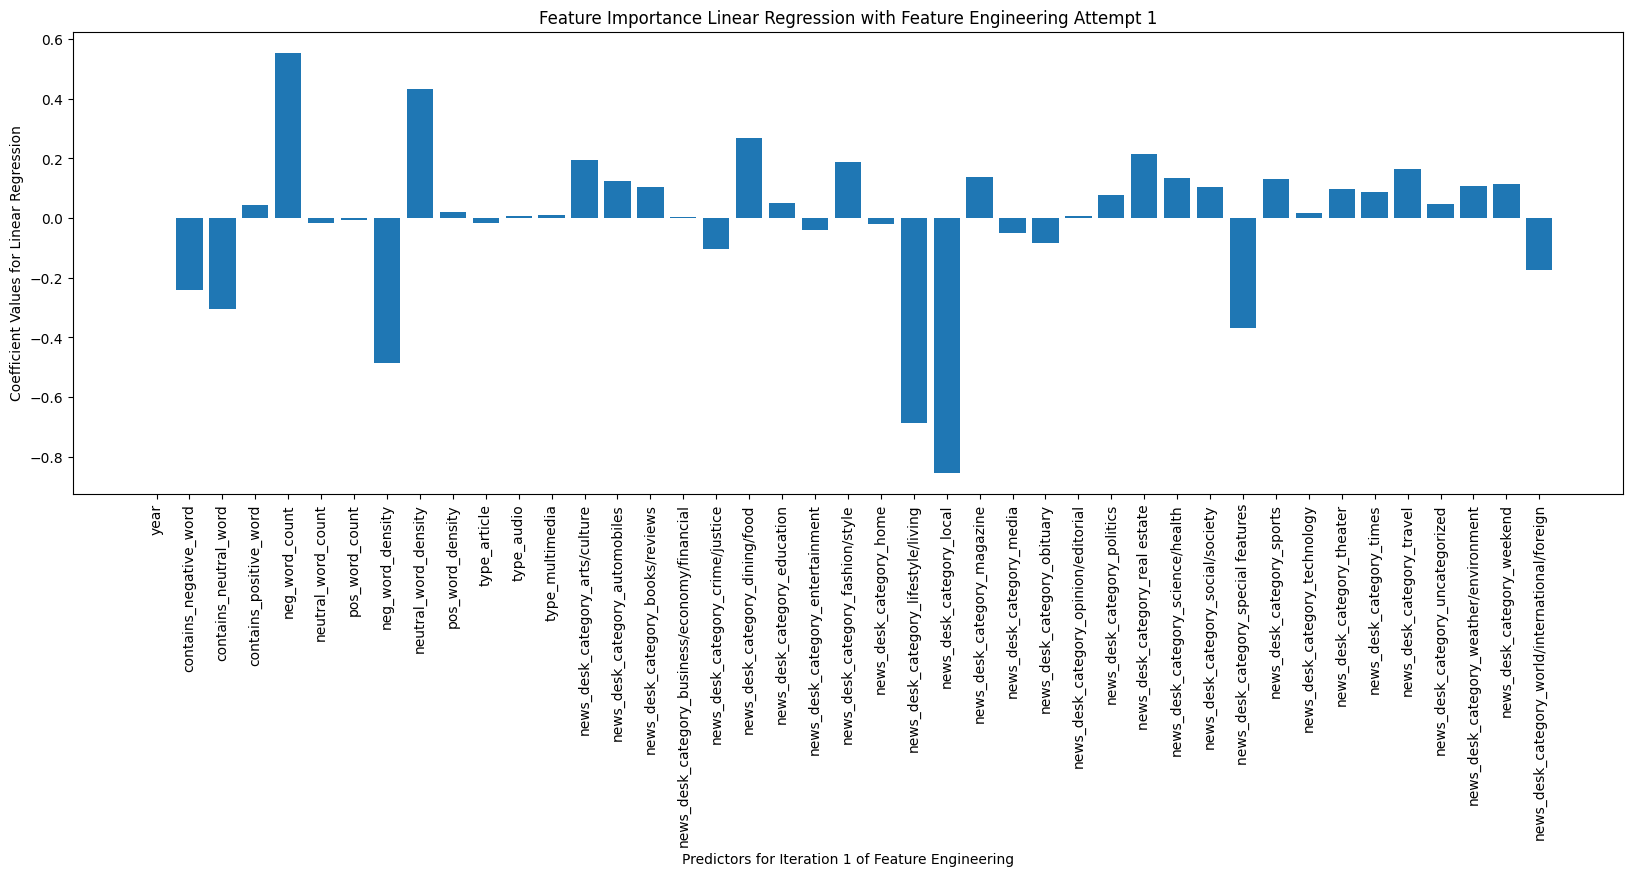

In [309]:
plt.figure(figsize=(20, 6))
plt.bar(predictors, lreg1.coef_)
plt.xticks(rotation=90)
plt.xlabel('Predictors for Iteration 1 of Feature Engineering')
plt.ylabel('Coefficient Values for Linear Regression')
plt.title('Feature Importance Linear Regression with Feature Engineering Attempt 1')
plt.show()

Interestingly enough, some news desk categories like lifestyling, local, and special features have coefficients with quite large absolute values, which means that they have quite high predictive power. 

In [310]:
fit_regressors('decision_tree', df_5k_copy, test_set_copy)

Train Accuracy: 0.6822
Test Accuracy: 0.5200066688896299
Negative Train Accuracy: 0.49310344827586206
Negative Test Accuracy: 0.34308663224325875
Neutral Train Accuracy: 0.9411525974025974
Neutral Test Accuracy: 0.8075862068965517
Positive Train Accuracy: 0.34714548802946593
Positive Test Accuracy: 0.13210332103321032


Just so we can see what is going on, let's look at what these decision trees may look like, and see some feature importance with MDI.

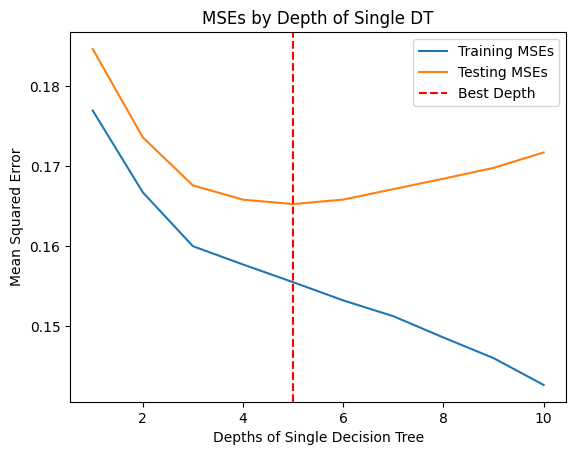

In [311]:
training_mses = []
testing_mses = []
# See predictive ability by depth

depths = [depth for depth in range(1, 11)]
for depth in depths:
    dt_reg = DecisionTreeRegressor(max_depth=depth)
    dt_reg.fit(X_train, y_train)
    y_train_pred = dt_reg.predict(X_train)
    y_test_pred = dt_reg.predict(X_test)
    
    training_mse = mean_squared_error(y_train_pred, y_train)
    testing_mse = mean_squared_error(y_test, y_test_pred)
    
    training_mses.append(training_mse)
    testing_mses.append(testing_mse)
    
plt.plot(depths, training_mses, label='Training MSEs')
plt.plot(depths, testing_mses, label='Testing MSEs')
best_dt_depth = testing_mses.index(min(testing_mses)) + 1
plt.axvline(best_dt_depth, color='red', linestyle='dashed',
            label='Best Depth')
plt.title('MSEs by Depth of Single DT')
plt.xlabel('Depths of Single Decision Tree')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


In [312]:
print(f'Best performance is achieved at {best_dt_depth}')

Best performance is achieved at 5


Here is the structure of the best performing single decision tree:


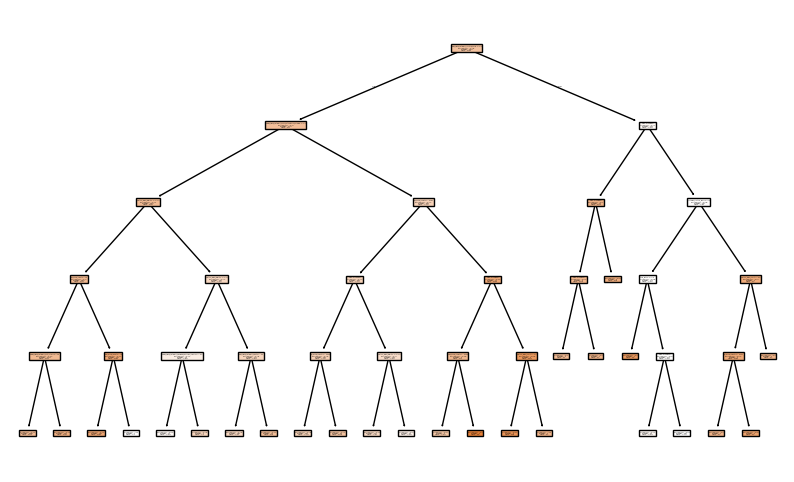

In [313]:
# Plot the decision tree with the best depth
dt_reg = DecisionTreeRegressor(max_depth=best_dt_depth)
dt_reg.fit(X_train, y_train)
print('Here is the structure of the best performing single decision tree:')

plt.figure(figsize=(10, 6))
plot_tree(dt_reg, feature_names=predictors, filled=True)
plt.show()

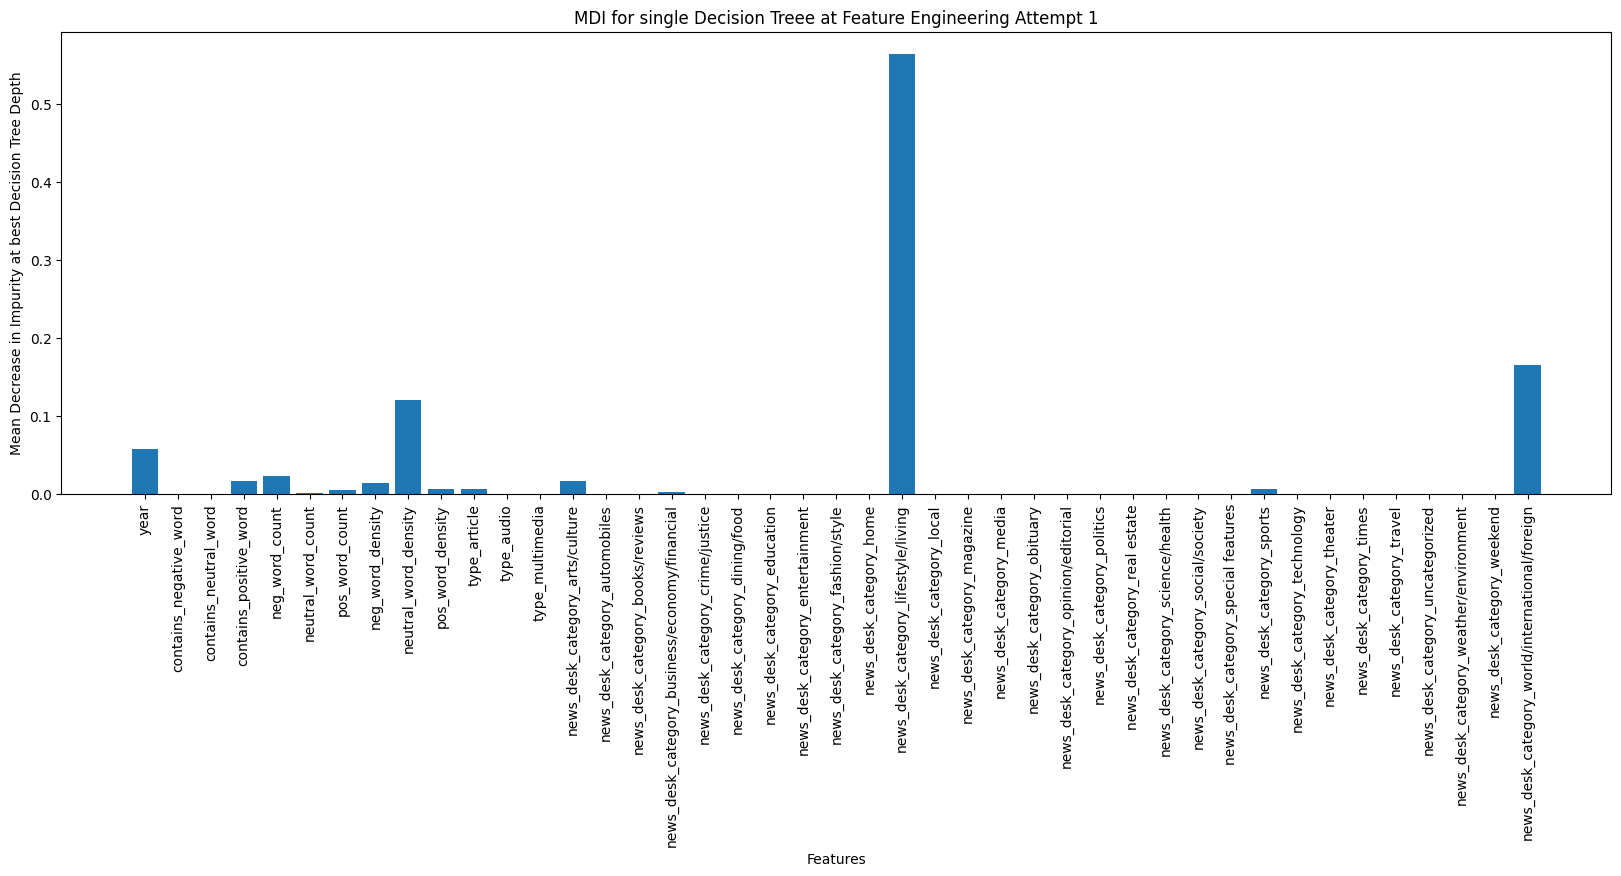

In [314]:
plt.figure(figsize=(20, 6))
plt.bar(predictors, dt_reg.feature_importances_)
plt.xticks(rotation=90)
plt.ylabel('Mean Decrease in Impurity at best Decision Tree Depth')
plt.xlabel('Features')
plt.title('MDI for single Decision Treee at Feature Engineering Attempt 1')
plt.show()

<div style="background: orange; color: black; padding: 5px">
    <h5>
       Next we will train a random forset:  
    </h5>
</div>


In [315]:
fit_regressors('random_forest', df_5k_copy, test_set_copy)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'max_depth': 11, 'n_estimators': 150}
Best Score: -0.16056985159014867
Train Accuracy: 0.5942
Test Accuracy: 0.5468489496498833
Negative Train Accuracy: 0.3786206896551724
Negative Test Accuracy: 0.3057946069994263
Neutral Train Accuracy: 0.9655032467532467
Neutral Test Accuracy: 0.9403448275862069
Positive Train Accuracy: 0.03959484346224678
Positive Test Accuracy: 0.014760147601476014


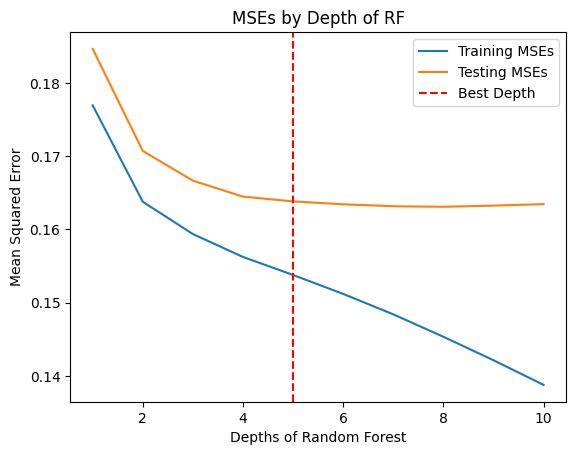

In [316]:
# Try starting with random forest depth 
n_estimators = 100

training_mses = []
testing_mses = []
# See predictive ability by depth

depths = [depth for depth in range(1, 11)]
for depth in depths:
    rf_reg = RandomForestRegressor(max_depth=depth,
                                random_state=109,
                                n_estimators=n_estimators)
    rf_reg.fit(X_train, y_train)
    y_train_pred = rf_reg.predict(X_train)
    y_test_pred = rf_reg.predict(X_test)
    
    training_mse = mean_squared_error(y_train_pred, y_train)
    testing_mse = mean_squared_error(y_test, y_test_pred)
    
    training_mses.append(training_mse)
    testing_mses.append(testing_mse)
    
plt.plot(depths, training_mses, label='Training MSEs')
plt.plot(depths, testing_mses, label='Testing MSEs')
plt.axvline(best_dt_depth, color='red', linestyle='dashed',
            label='Best Depth')
plt.title('MSEs by Depth of RF')
plt.xlabel('Depths of Random Forest')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

<div style="background: orange; color: black; padding: 5px">
    <h5>
        Now gradient boosting. 
    </h5>
</div>


In [317]:
fit_regressors('gradient_boosting', df_5k_copy, test_set_copy)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}
Best Score: -0.156272082259871
Train Accuracy: 0.5692
Test Accuracy: 0.5438479493164388
Negative Train Accuracy: 0.30551724137931036
Negative Test Accuracy: 0.27710843373493976
Neutral Train Accuracy: 0.9679383116883117
Neutral Test Accuracy: 0.9551724137931035
Positive Train Accuracy: 0.016574585635359115
Positive Test Accuracy: 0.006642066420664207


<div style="background: orange; color: black; padding: 5px">
    <h5>
        We can think of our previous iteration of feature engineering as having 3 different buckets. We have a negative bucket of negative words, and the same thing for neutral and positive. This is a pretty primitive model, as a lot of words get bunched up into the same bucket, and as a result we may lose some nuance. For example, some words like "deaths" are very negative, but they get grouped with other words like "job", which are not as negative. This next iteration of feature engineering basically dumps these words that we selected out of the buckets and encodes individual indicator features for whether or not that specific word appears in each headline. That hopefully should allow our models to capture more nuance of these 60 or so words that we picked out. 
    </h5>
</div>


In [318]:
all_words = negative_words + neutral_words + positive_words
def feature_engineer2(df):
    for word in all_words:
        df[word] = 0
    
    for idx, row in df.iterrows():
        for word in all_words:
            if word in row['headline']:
                df.loc[idx, word] = 1
                
    df = pd.get_dummies(df, columns=['type', 'news_desk_category'])
    df.drop(['headline', 'sentiment_class', 'GPT_class', 'headline_no_stopwords'], axis=1, inplace=True)
    return df

In [319]:
df_5k_copy = df_5k.copy()
test_set_copy = test_set.copy()

df_5k_copy = feature_engineer2(df_5k_copy)
test_set_copy = feature_engineer2(test_set_copy)

In [320]:
fit_regressors('linear', df_5k_copy, test_set_copy)

Train Accuracy: 0.567
Test Accuracy: 0.5485161720573525
Negative Train Accuracy: 0.28620689655172415
Negative Test Accuracy: 0.25817555938037867
Neutral Train Accuracy: 0.9715909090909091
Neutral Test Accuracy: 0.9644827586206897
Positive Train Accuracy: 0.02394106813996317
Positive Test Accuracy: 0.03173431734317343


In [321]:
linreg = LinearRegression()
regression_response = 'GPT_score'
classification_response = 'GPT_class'
predictors = [col for col in df_5k_copy.columns if (col != regression_response and col != classification_response)]

X_train = df_5k_copy[predictors]
y_train = df_5k_copy[regression_response]

X_test = test_set_copy[predictors]
y_test = test_set_copy[regression_response]

lreg1 = lreg.fit(X_train, y_train)
y_pred = lreg1.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'See linear regression mse: {mse}')

See linear regression mse: 0.1561397447813931


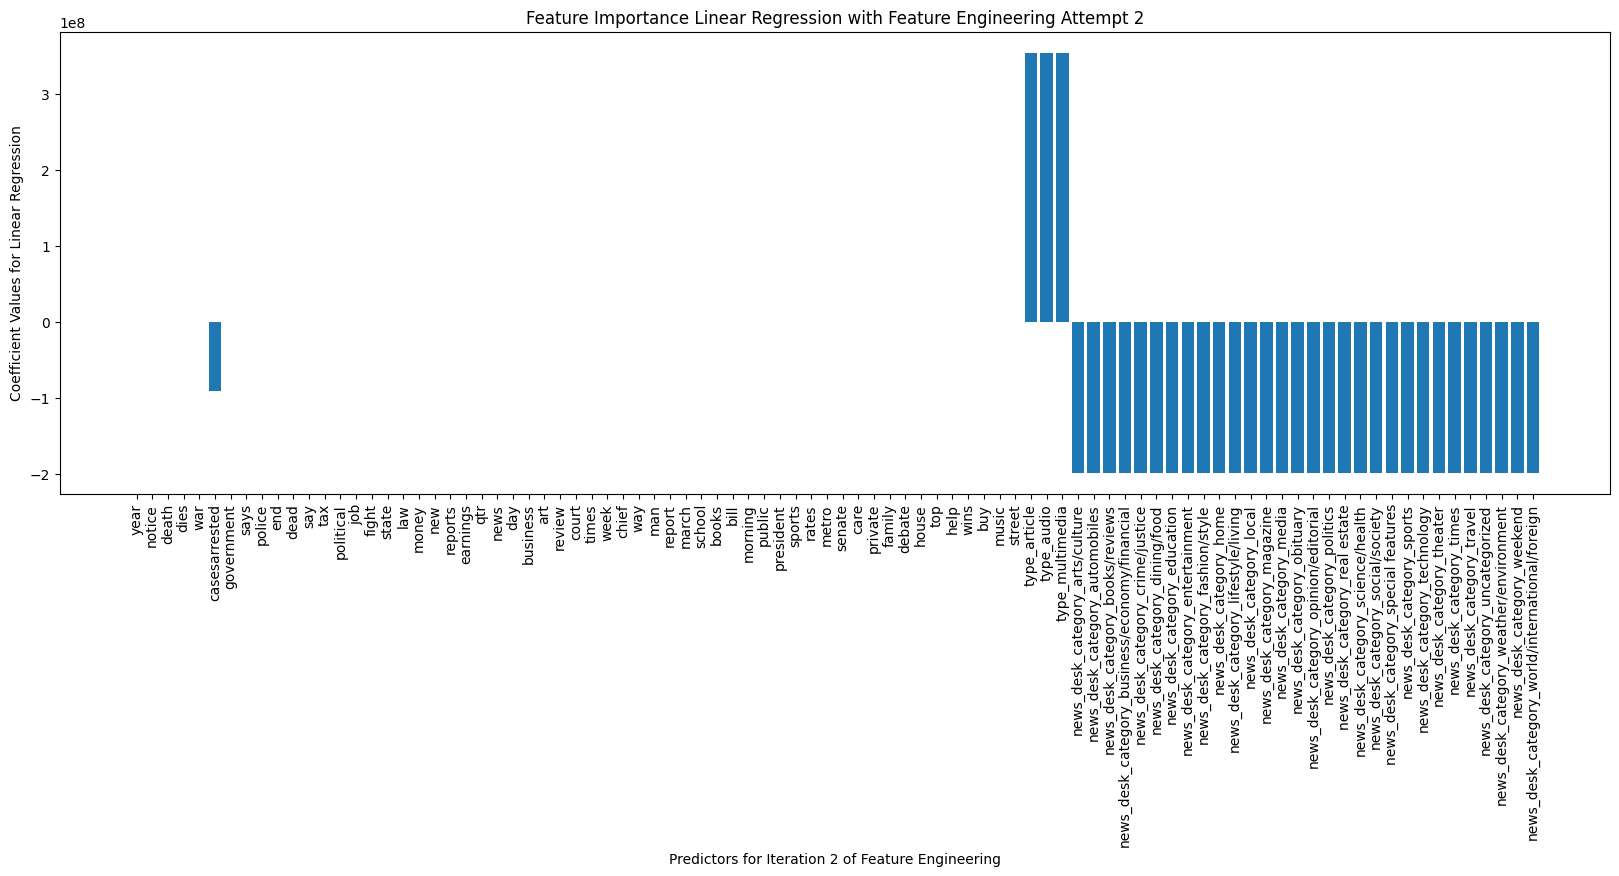

In [322]:
plt.figure(figsize=(20, 6))
plt.bar(predictors, lreg1.coef_)
plt.xticks(rotation=90)
plt.xlabel('Predictors for Iteration 2 of Feature Engineering')
plt.ylabel('Coefficient Values for Linear Regression')
plt.title('Feature Importance Linear Regression with Feature Engineering Attempt 2')
plt.show()

In [323]:
fit_regressors('decision_tree', df_5k_copy, test_set_copy)

Train Accuracy: 0.7548
Test Accuracy: 0.5140046682227409
Negative Train Accuracy: 0.6186206896551724
Negative Test Accuracy: 0.3689041881812966
Neutral Train Accuracy: 0.958198051948052
Neutral Test Accuracy: 0.7772413793103449
Positive Train Accuracy: 0.47513812154696133
Positive Test Accuracy: 0.13726937269372694


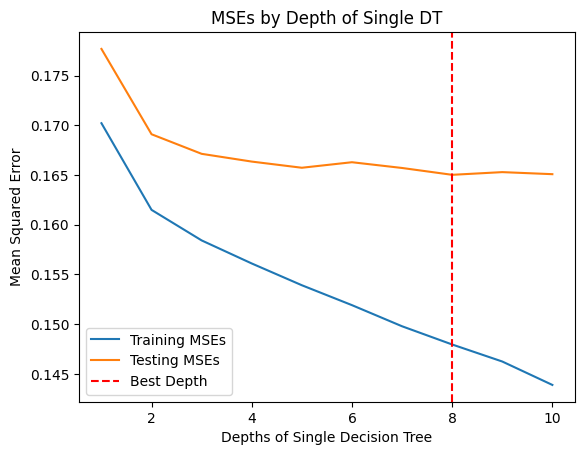

Best performance is achieved at 8


In [324]:
training_mses = []
testing_mses = []
# See predictive ability by depth

depths = [depth for depth in range(1, 11)]
for depth in depths:
    dt_reg = DecisionTreeRegressor(max_depth=depth)
    dt_reg.fit(X_train, y_train)
    y_train_pred = dt_reg.predict(X_train)
    y_test_pred = dt_reg.predict(X_test)
    
    training_mse = mean_squared_error(y_train_pred, y_train)
    testing_mse = mean_squared_error(y_test, y_test_pred)
    
    training_mses.append(training_mse)
    testing_mses.append(testing_mse)
    
plt.plot(depths, training_mses, label='Training MSEs')
plt.plot(depths, testing_mses, label='Testing MSEs')
best_dt_depth = testing_mses.index(min(testing_mses)) + 1
plt.axvline(best_dt_depth, color='red', linestyle='dashed',
            label='Best Depth')
plt.title('MSEs by Depth of Single DT')
plt.xlabel('Depths of Single Decision Tree')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()
print(f'Best performance is achieved at {best_dt_depth}')

Here is the structure of the best performing single decision tree:


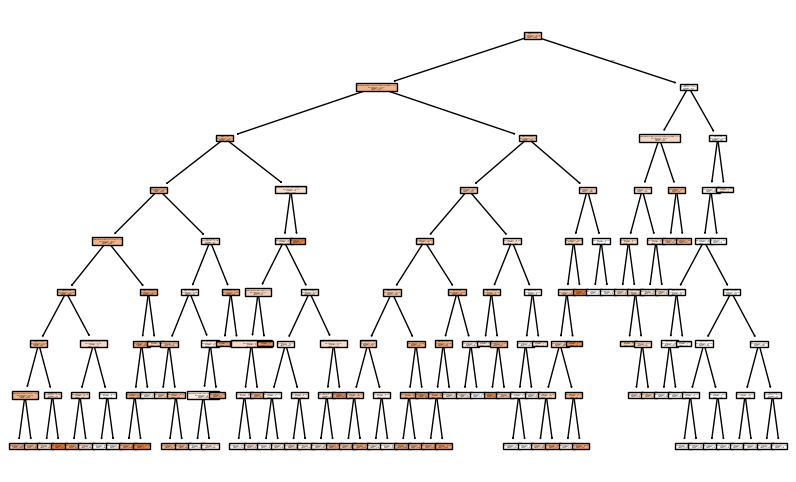

In [325]:
# Plot the decision tree with the best depth
dt_reg = DecisionTreeRegressor(max_depth=best_dt_depth)
dt_reg.fit(X_train, y_train)
print('Here is the structure of the best performing single decision tree:')

plt.figure(figsize=(10, 6))
plot_tree(dt_reg, feature_names=predictors, filled=True)
plt.show()

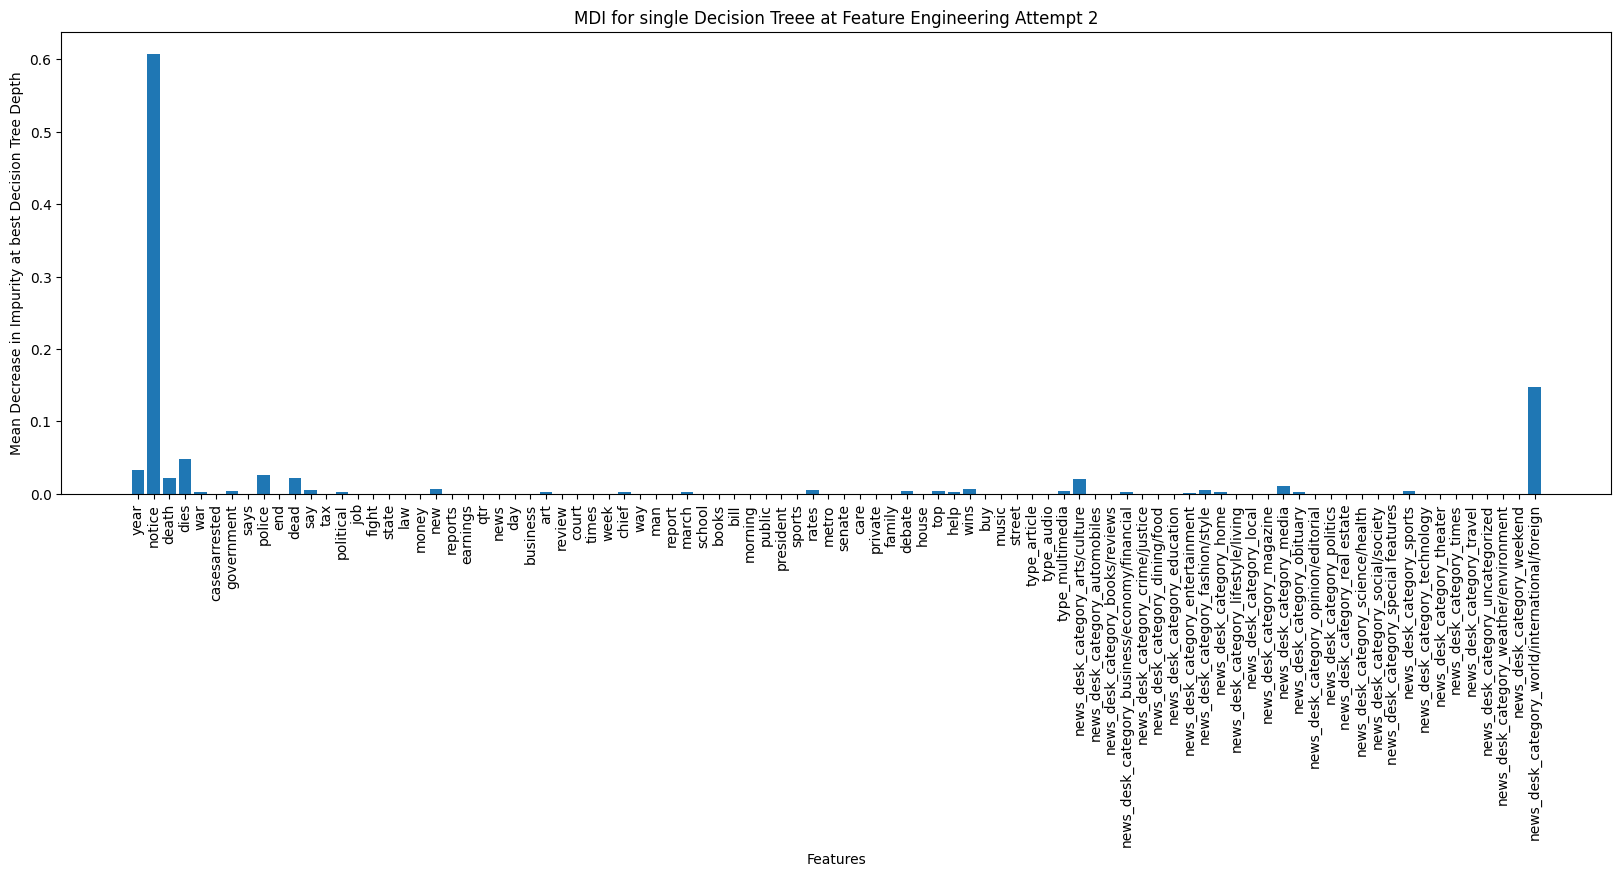

In [326]:
plt.figure(figsize=(20, 6))
plt.bar(predictors, dt_reg.feature_importances_)
plt.xticks(rotation=90)
plt.ylabel('Mean Decrease in Impurity at best Decision Tree Depth')
plt.xlabel('Features')
plt.title('MDI for single Decision Treee at Feature Engineering Attempt 2')
plt.show()

In [327]:
fit_regressors('random_forest', df_5k_copy, test_set_copy)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'max_depth': 11, 'n_estimators': 115}
Best Score: -0.15505807428031698
Train Accuracy: 0.5808
Test Accuracy: 0.5493497832610871
Negative Train Accuracy: 0.3255172413793103
Negative Test Accuracy: 0.2707974756167527
Neutral Train Accuracy: 0.9825487012987013
Neutral Test Accuracy: 0.9717241379310345
Positive Train Accuracy: 0.010128913443830571
Positive Test Accuracy: 0.0036900369003690036


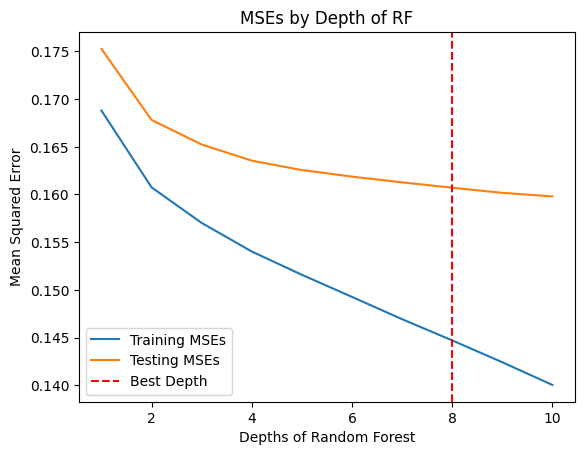

In [328]:
# Try starting with random forest depth 
n_estimators = 100

training_mses = []
testing_mses = []
# See predictive ability by depth

depths = [depth for depth in range(1, 11)]
for depth in depths:
    rf_reg = RandomForestRegressor(max_depth=depth,
                                random_state=109,
                                n_estimators=n_estimators)
    rf_reg.fit(X_train, y_train)
    y_train_pred = rf_reg.predict(X_train)
    y_test_pred = rf_reg.predict(X_test)
    
    training_mse = mean_squared_error(y_train_pred, y_train)
    testing_mse = mean_squared_error(y_test, y_test_pred)
    
    training_mses.append(training_mse)
    testing_mses.append(testing_mse)
    
plt.plot(depths, training_mses, label='Training MSEs')
plt.plot(depths, testing_mses, label='Testing MSEs')
plt.axvline(best_dt_depth, color='red', linestyle='dashed',
            label='Best Depth')
plt.title('MSEs by Depth of RF')
plt.xlabel('Depths of Random Forest')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [329]:
fit_regressors('gradient_boosting', df_5k_copy, test_set_copy)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 75}
Best Score: -0.15108858458592841
Train Accuracy: 0.5766
Test Accuracy: 0.5498499499833278
Negative Train Accuracy: 0.3
Negative Test Accuracy: 0.25760183591508895
Neutral Train Accuracy: 0.9866071428571429
Neutral Test Accuracy: 0.9772413793103448
Positive Train Accuracy: 0.01565377532228361
Positive Test Accuracy: 0.01107011070110701


<h5 style="background: orange; color: black; padding: 5px">
    Now we will try and improve on the second iteration of feature engineering. In the previous iteration, we saw that a single decision, even at the best depth, struggled the most, which shouldn't surprise us. Linear regression did solid with around a 54 percent accuracy, while random forest and gradient boosting were better, with 0.55 percent accuracy. We'll try and get more granular features for our next few models. Above, through our domain knowledge of the English language, we filtered out words that didn't make sense to include in the negative, neutral, or positive categories. However, now, we will disregard that filtering and simply include the top 500 most frequently occurring words in the training data headlines. These will be indicator variables for whether or not that keyword appeared. 
</h5>

In [330]:
def feature_engineer3(df):
    K = 500
    topK_words = dict(sorted(word_counts.items(), key = lambda x: x[1], reverse = True)[:K])
    for word in topK_words:
        df[word] = 0
    
    for idx, row in df.iterrows():
        for word in topK_words:
            if word in row['headline']:
                df.loc[idx, word] = 1
                
    df = pd.get_dummies(df, columns=['type', 'news_desk_category'])
    df.drop(['headline', 'sentiment_class', 'GPT_class', 'headline_no_stopwords'], axis=1, inplace=True)
    return df

In [331]:
df_5k_copy = df_5k.copy()
test_set_copy = test_set.copy()

df_5k_copy = feature_engineer3(df_5k_copy)
test_set_copy = feature_engineer3(test_set_copy)

/var/folders/04/2hwl1j9x5yl1hdpnd9k3jlqw0000gn/T/ipykernel_2861/473532793.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word] = 0
/var/folders/04/2hwl1j9x5yl1hdpnd9k3jlqw0000gn/T/ipykernel_2861/473532793.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word] = 0
/var/folders/04/2hwl1j9x5yl1hdpnd9k3jlqw0000gn/T/ipykernel_2861/473532793.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

In [332]:
fit_regressors('linear', df_5k_copy, test_set_copy)

Train Accuracy: 0.6218
Test Accuracy: 0.56702234078026
Negative Train Accuracy: 0.4531034482758621
Negative Test Accuracy: 0.36947791164658633
Neutral Train Accuracy: 0.9387175324675324
Neutral Test Accuracy: 0.9120689655172414
Positive Train Accuracy: 0.1279926335174954
Positive Test Accuracy: 0.08265682656826569


In [333]:
linreg = LinearRegression()
regression_response = 'GPT_score'
classification_response = 'GPT_class'
predictors = [col for col in df_5k_copy.columns if (col != regression_response and col != classification_response)]

X_train = df_5k_copy[predictors]
y_train = df_5k_copy[regression_response]

X_test = test_set_copy[predictors]
y_test = test_set_copy[regression_response]

lreg1 = lreg.fit(X_train, y_train)
y_pred = lreg1.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'See linear regression mse: {mse}')

See linear regression mse: 0.15302122568201723


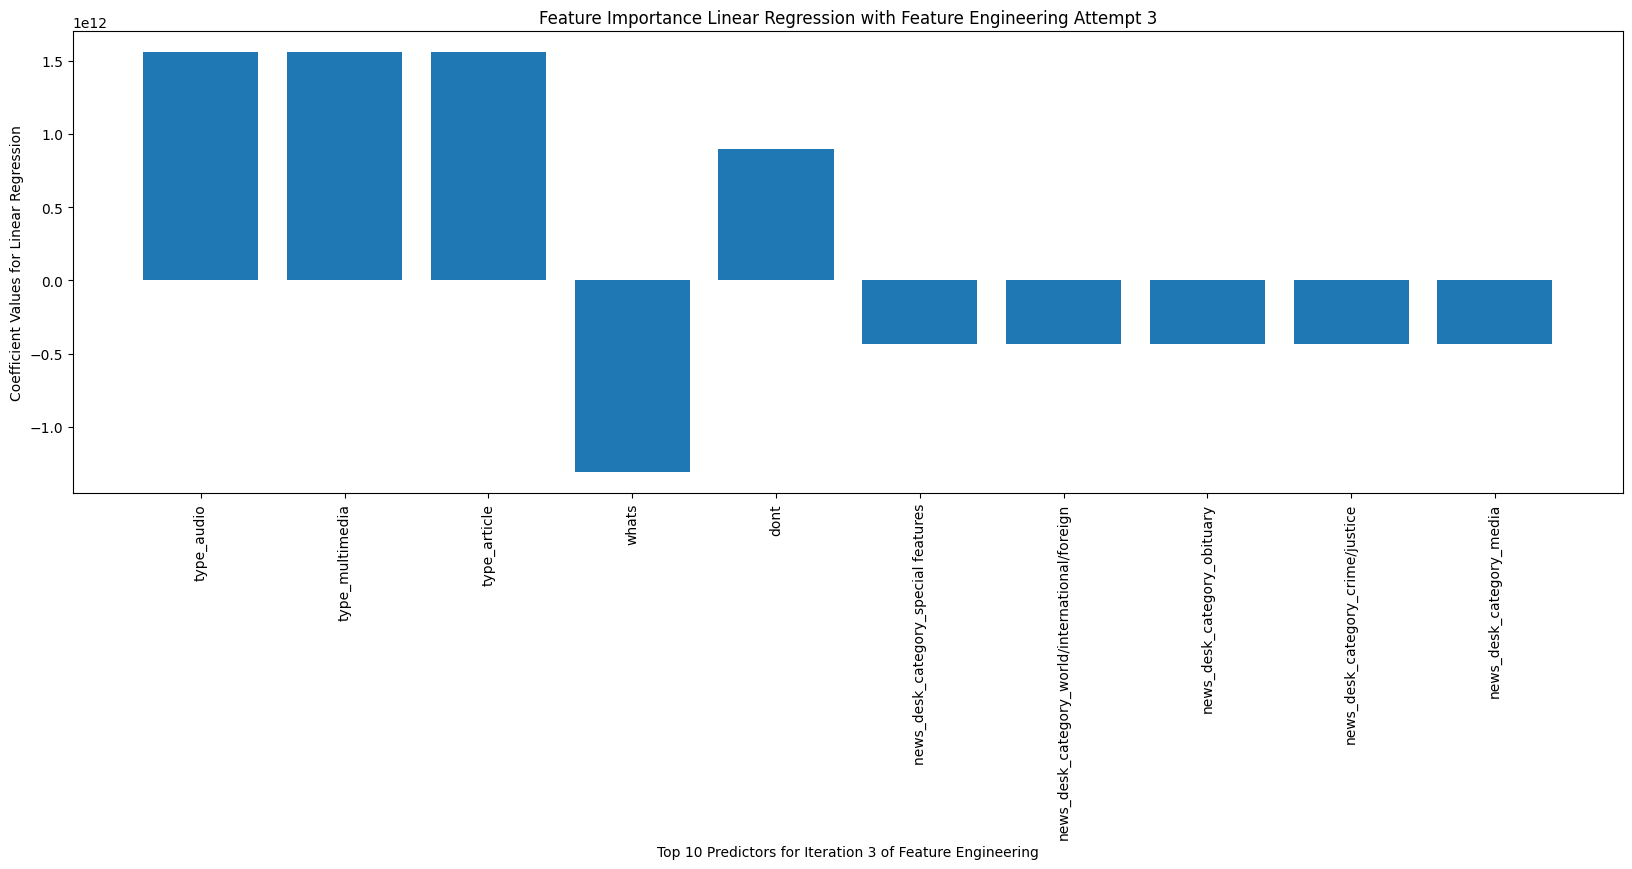

In [334]:
coefficients = np.ravel(lreg1.coef_)
top_indices = np.argsort(np.abs(coefficients))[-10:][::-1]
top_predictors = [predictors[i] for i in top_indices]
top_coefficients = coefficients[top_indices]

plt.figure(figsize=(20, 6))
plt.bar(top_predictors, top_coefficients)
plt.xticks(rotation=90)
plt.xlabel('Top 10 Predictors for Iteration 3 of Feature Engineering')
plt.ylabel('Coefficient Values for Linear Regression')
plt.title('Feature Importance Linear Regression with Feature Engineering Attempt 3')
plt.show()


In [335]:
fit_regressors('decision_tree', df_5k_copy, test_set_copy)

Train Accuracy: 0.974
Test Accuracy: 0.5123374458152717
Negative Train Accuracy: 0.9758620689655172
Negative Test Accuracy: 0.5289730349971313
Neutral Train Accuracy: 0.9918831168831169
Neutral Test Accuracy: 0.6224137931034482
Positive Train Accuracy: 0.930939226519337
Positive Test Accuracy: 0.25535055350553504


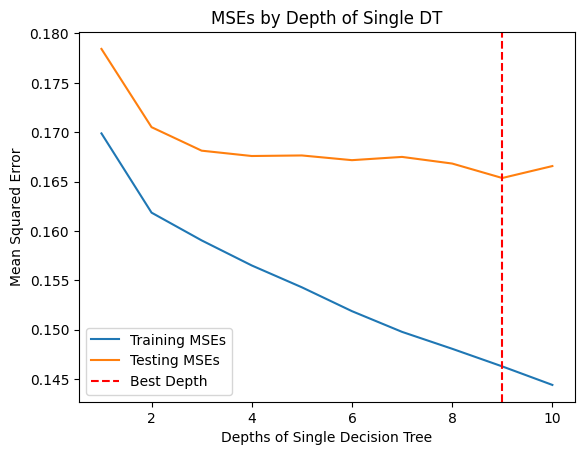

Best performance is achieved at 9


In [336]:
training_mses = []
testing_mses = []
# See predictive ability by depth

depths = [depth for depth in range(1, 11)]
for depth in depths:
    dt_reg = DecisionTreeRegressor(max_depth=depth)
    dt_reg.fit(X_train, y_train)
    y_train_pred = dt_reg.predict(X_train)
    y_test_pred = dt_reg.predict(X_test)
    
    training_mse = mean_squared_error(y_train_pred, y_train)
    testing_mse = mean_squared_error(y_test, y_test_pred)
    
    training_mses.append(training_mse)
    testing_mses.append(testing_mse)
    
plt.plot(depths, training_mses, label='Training MSEs')
plt.plot(depths, testing_mses, label='Testing MSEs')
best_dt_depth = testing_mses.index(min(testing_mses)) + 1
plt.axvline(best_dt_depth, color='red', linestyle='dashed',
            label='Best Depth')
plt.title('MSEs by Depth of Single DT')
plt.xlabel('Depths of Single Decision Tree')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()
print(f'Best performance is achieved at {best_dt_depth}')

In [337]:
fit_regressors('random_forest', df_5k_copy, test_set_copy)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'max_depth': 12, 'n_estimators': 115}
Best Score: -0.15103038342662506
Train Accuracy: 0.5924
Test Accuracy: 0.5545181727242414
Negative Train Accuracy: 0.3489655172413793
Negative Test Accuracy: 0.2782558806655192
Neutral Train Accuracy: 0.9959415584415584
Neutral Test Accuracy: 0.9796551724137931
Positive Train Accuracy: 0.001841620626151013
Positive Test Accuracy: 0.0


In [338]:
fit_regressors('gradient_boosting', df_5k_copy, test_set_copy)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Best Score: -0.1446959438932964
Train Accuracy: 0.5994
Test Accuracy: 0.5600200066688896
Negative Train Accuracy: 0.3779310344827586
Negative Test Accuracy: 0.3017785427423982
Neutral Train Accuracy: 0.9902597402597403
Neutral Test Accuracy: 0.9741379310344828
Positive Train Accuracy: 0.008287292817679558
Positive Test Accuracy: 0.005904059040590406


<h5 style="background: orange; color: black; padding: 5px">
    Our previous iteration of feature engineering did improve our accuracy scores slightly. Random forest struggled relative to the other models, which was surprising. Perhaps if we were to tune the hyperparameters even more, RF would perform better, although we did try the GridCV search function for our RF. Gradient boosting performed second best, while linear regression pulled ahead and was the best performing model.
</h5>

<h5 style="background: orange; color: black; padding: 5px">
    For our next iteration of feature engineering, we will try combining the feature engineering methods from iteration 1 and 3. We will still include the indicator features for the top 500 most frequently occurring words, however, we will bring back the three "buckets" of positive, neutral, and negative. Additionally, we will first try using the "buckets" that we came up with in iteration one. Then we will try using "buckets" imported from the NLTK libraries, which will give us large lists of words deemed positive, negative, and neutral. Note that NLTK doesn't have a set of neutral words that we can import, however, there is a large set of all words that we import, and we do set subtraction of all the positive and negative words, and then just take the top 4000. We then union these with our original buckets. 
</h5>

In [339]:
def feature_engineer4(df, pos_words, neg_words, neut_words):
    columns_to_drop = ['headline', 'sentiment_class', 'headline_no_stopwords', 'GPT_class']
    df = df.copy()  # Avoid SettingWithCopyWarning

    # Initialize new features
    df['contains_negative_word'] = 0
    df['contains_neutral_word'] = 0
    df['contains_positive_word'] = 0
    df['neg_word_count'] = 0
    df['neutral_word_count'] = 0
    df['pos_word_count'] = 0
    df['neg_word_density'] = 0.0
    df['neutral_word_density'] = 0.0
    df['pos_word_density'] = 0.0

    # Iterate over rows to compute values
    for idx, row in df.iterrows():
        words = row['headline'].split()  # Tokenize the headline
        total_words = len(words)

        # Initialize counters
        neg_count = 0
        neutral_count = 0
        pos_count = 0

        # Count words based on sentiment categories
        for word in words:
            if word in pos_words:
               neg_count += 1
            elif word in neg_words:
                neutral_count += 1
            elif word in neut_words:
                pos_count += 1

        # Set word counts
        df.loc[idx, 'neg_word_count'] = neg_count
        df.loc[idx, 'neutral_word_count'] = neutral_count
        df.loc[idx, 'pos_word_count'] = pos_count

        # Set "contains" flags
        if neg_count > 0:
            df.loc[idx, 'contains_negative_word'] = 1
        if neutral_count > 0:
            df.loc[idx, 'contains_neutral_word'] = 1
        if pos_count > 0:
            df.loc[idx, 'contains_positive_word'] = 1

        # Calculate word densities
        if total_words > 0:
            df.loc[idx, 'neg_word_density'] = neg_count / total_words
            df.loc[idx, 'neutral_word_density'] = neutral_count / total_words
            df.loc[idx, 'pos_word_density'] = pos_count / total_words
            
    K = 500
    topK_words = dict(sorted(word_counts.items(), key = lambda x: x[1], reverse = True)[:K])
    for word in topK_words:
        df[word] = 0
    
    for idx, row in df.iterrows():
        for word in topK_words:
            if word in row['headline']:
                df.loc[idx, word] = 1

    df = pd.get_dummies(df, columns=['type', 'news_desk_category'])
    df.drop(['headline', 'sentiment_class', 'GPT_class', 'headline_no_stopwords'], axis=1, inplace=True)
      
    return df

In [340]:
df_5k_copy = df_5k.copy()
test_set_copy = test_set.copy()

df_5k_copy = feature_engineer4(df_5k_copy, positive_words, negative_words, neutral_words)
test_set_copy = feature_engineer4(test_set_copy, positive_words, negative_words, neutral_words)

df_5k_copy.head() 

/var/folders/04/2hwl1j9x5yl1hdpnd9k3jlqw0000gn/T/ipykernel_2861/662317495.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word] = 0
/var/folders/04/2hwl1j9x5yl1hdpnd9k3jlqw0000gn/T/ipykernel_2861/662317495.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word] = 0
/var/folders/04/2hwl1j9x5yl1hdpnd9k3jlqw0000gn/T/ipykernel_2861/662317495.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

,year,GPT_score,contains_negative_word,contains_neutral_word,contains_positive_word,neg_word_count,neutral_word_count,pos_word_count,neg_word_density,neutral_word_density,...,news_desk_category_special features,news_desk_category_sports,news_desk_category_technology,news_desk_category_theater,news_desk_category_times,news_desk_category_travel,news_desk_category_uncategorized,news_desk_category_weather/environment,news_desk_category_weekend,news_desk_category_world/international/foreign
0,0,0.2,0,0,0,0,0,0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,0,-0.5,0,0,0,0,0,0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,0,-0.7,0,0,1,0,0,1,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,0,-0.3,0,0,0,0,0,0,0.0,0.0,...,False,True,False,False,False,False,False,False,False,False
4,0,0.5,0,0,0,0,0,0,0.0,0.0,...,False,False,False,False,False,True,False,False,False,False


In [341]:
perc = len(df_5k_copy[(df_5k_copy['contains_negative_word'] == 0) &
      (df_5k_copy['contains_neutral_word'] == 0) &
      (df_5k_copy['contains_positive_word'] == 0)]) / len(df_5k_copy) * 100

print(f"Percentage of feature engineering data that doesn't have at least one negative, neutral, or positive word in it:")
print(perc, "%")

Percentage of feature engineering data that doesn't have at least one negative, neutral, or positive word in it:
75.76 %


In [342]:
fit_regressors('linear', df_5k_copy, test_set_copy)

Train Accuracy: 0.6212
Test Accuracy: 0.5695231743914638
Negative Train Accuracy: 0.4586206896551724
Negative Test Accuracy: 0.38496844520940904
Neutral Train Accuracy: 0.9334415584415584
Neutral Test Accuracy: 0.9075862068965517
Positive Train Accuracy: 0.1298342541436464
Positive Test Accuracy: 0.08339483394833948


In [343]:
fit_regressors('decision_tree', df_5k_copy, test_set_copy)

Train Accuracy: 0.974
Test Accuracy: 0.5181727242414138
Negative Train Accuracy: 0.9758620689655172
Negative Test Accuracy: 0.5232358003442341
Neutral Train Accuracy: 0.9918831168831169
Neutral Test Accuracy: 0.6413793103448275
Positive Train Accuracy: 0.930939226519337
Positive Test Accuracy: 0.24797047970479705


In [344]:
fit_regressors('random_forest', df_5k_copy, test_set_copy)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'max_depth': 12, 'n_estimators': 115}
Best Score: -0.14798472224075448
Train Accuracy: 0.6052
Test Accuracy: 0.5561853951317106
Negative Train Accuracy: 0.39586206896551723
Negative Test Accuracy: 0.3023522662076879
Neutral Train Accuracy: 0.9898538961038961
Neutral Test Accuracy: 0.9662068965517241
Positive Train Accuracy: 0.011970534069981584
Positive Test Accuracy: 0.0051660516605166054


In [345]:
fit_regressors('gradient_boosting', df_5k_copy, test_set_copy)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100}
Best Score: -0.14337953075626447
Train Accuracy: 0.5844
Test Accuracy: 0.5585195065021674
Negative Train Accuracy: 0.3386206896551724
Negative Test Accuracy: 0.2931726907630522
Neutral Train Accuracy: 0.9849837662337663
Neutral Test Accuracy: 0.9779310344827586
Positive Train Accuracy: 0.003683241252302026
Positive Test Accuracy: 0.002214022140221402


<h5 style="background: orange; color: black; padding: 5px">
    Linear was the best performance that we saw from any model. It was nice to see that with every iteration, the scores did get better with more and more sophisticated feature engineering. Now, we will try iterative testing, increasing the size of the training set starting at 5000 and incrementing 1000. Just by principle, we would expect the performance to go up with more training data. 
</h5>

In [346]:
# Initialize results
train_accuracies = []
test_accuracies = []

# Initial split: Use the first 5,000 rows as the initial training set
train_df = df_5k_copy.copy()

# Iteratively test and retrain
for i in range(0, len(test_set_copy), 1000):
    # Select the next 1,000 rows as the test set
    test_df = test_set_copy.iloc[i:i + 1000]
    
    # Run the regression function on the current train and test sets
    fit_regressors('linear', train_df, test_df)
    
    # Append the test set to the training set for the next iteration
    train_df = pd.concat([train_df, test_df], ignore_index=True)

# Display the accuracies after all iterations
print("Train Accuracies per Iteration:", train_accuracies)
print("Test Accuracies per Iteration:", test_accuracies)

Train Accuracy: 0.6212
Test Accuracy: 0.564
Negative Train Accuracy: 0.4586206896551724
Negative Test Accuracy: 0.3741258741258741
Neutral Train Accuracy: 0.9334415584415584
Neutral Test Accuracy: 0.8949494949494949
Positive Train Accuracy: 0.1298342541436464
Positive Test Accuracy: 0.0639269406392694
Train Accuracy: 0.6153333333333333
Test Accuracy: 0.564
Negative Train Accuracy: 0.4441244239631336
Negative Test Accuracy: 0.34843205574912894
Neutral Train Accuracy: 0.9354511659344373
Neutral Test Accuracy: 0.9042769857433809
Positive Train Accuracy: 0.11724137931034483
Positive Test Accuracy: 0.09009009009009009
Train Accuracy: 0.606
Test Accuracy: 0.588
Negative Train Accuracy: 0.42609985170538806
Negative Test Accuracy: 0.3908450704225352
Neutral Train Accuracy: 0.9353623188405797
Neutral Test Accuracy: 0.9240246406570842
Positive Train Accuracy: 0.10019646365422397
Positive Test Accuracy: 0.11790393013100436
Train Accuracy: 0.607875
Test Accuracy: 0.543
Negative Train Accuracy: 0.4

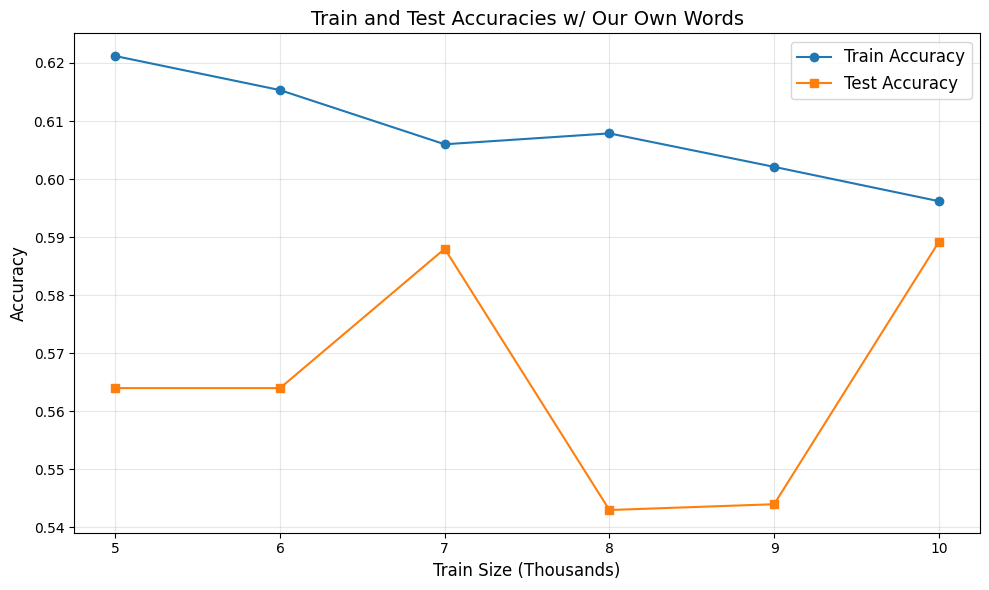

In [347]:
# Assuming `train_accuracies` and `test_accuracies` are populated from the iterations
train_sizes = ['5', '6', '7', '8', '9', '10']  # Number of iterations

plt.figure(figsize=(10, 6))

# Plot train accuracies
plt.plot(train_sizes, train_accuracies, label='Train Accuracy', marker='o')

# Plot test accuracies
plt.plot(train_sizes, test_accuracies, label='Test Accuracy', marker='s')

# Customize the plot
plt.title('Train and Test Accuracies w/ Our Own Words', fontsize=14)
plt.xlabel('Train Size (Thousands)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(train_sizes)  # Show each iteration on the x-axis
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

<h5 style="background: orange; color: black; padding: 5px">
    After using the positive/negative/neutral word list that we generated, the train and test accuracy did not improve like we desired. Therefore, we decided to also include predefined positive/negative/neatral words found in the NLTK library and worked with a larger and more comprehensive list./h5>5>

In [348]:
from nltk.corpus import words

# Engineering features based on sentiment words
positive_words2 = set(opinion_lexicon.positive())
negative_words2 = set(opinion_lexicon.negative())

all_words = set(words.words())

neutral_words2 = all_words - positive_words2 - negative_words2

# Convert to lists for indexing
positive_words2 = list(positive_words2)[:2000] + positive_words
negative_words2 = list(negative_words2)[:4000] + negative_words
neutral_words2 = list(neutral_words2)[:8000] + neutral_words

# Check lengths
print('Positive Words:', len(positive_words2))
print('Negative Words:', len(negative_words2))
print('Neutral Words:', len(neutral_words2))

df_5k_nltk = df_5k.copy()
test_set_nltk = test_set.copy()

df_5k_copy = feature_engineer4(df_5k_nltk, positive_words2, negative_words2, neutral_words2)
test_set_copy = feature_engineer4(test_set_nltk, positive_words2, negative_words2, neutral_words2)



Positive Words: 2006
Negative Words: 4018
Neutral Words: 8032


/var/folders/04/2hwl1j9x5yl1hdpnd9k3jlqw0000gn/T/ipykernel_2861/662317495.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word] = 0
/var/folders/04/2hwl1j9x5yl1hdpnd9k3jlqw0000gn/T/ipykernel_2861/662317495.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word] = 0
/var/folders/04/2hwl1j9x5yl1hdpnd9k3jlqw0000gn/T/ipykernel_2861/662317495.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

In [349]:
fit_regressors('linear', df_5k_copy, test_set_copy)

Train Accuracy: 0.6436
Test Accuracy: 0.592864288096032
Negative Train Accuracy: 0.5317241379310345
Negative Test Accuracy: 0.4538152610441767
Neutral Train Accuracy: 0.9155844155844156
Neutral Test Accuracy: 0.8882758620689655
Positive Train Accuracy: 0.17587476979742173
Positive Test Accuracy: 0.13948339483394834


In [350]:
fit_regressors('decision_tree', df_5k_copy, test_set_copy)

Train Accuracy: 0.984
Test Accuracy: 0.5385128376125375
Negative Train Accuracy: 0.9917241379310345
Negative Test Accuracy: 0.5547905909351692
Neutral Train Accuracy: 0.9935064935064936
Neutral Test Accuracy: 0.6431034482758621
Positive Train Accuracy: 0.9521178637200737
Positive Test Accuracy: 0.2937269372693727


In [351]:
fit_regressors('random_forest', df_5k_copy, test_set_copy)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'max_depth': 12, 'n_estimators': 115}
Best Score: -0.13365410870504257
Train Accuracy: 0.6316
Test Accuracy: 0.5820273424474824
Negative Train Accuracy: 0.5551724137931034
Negative Test Accuracy: 0.46930579460699945
Neutral Train Accuracy: 0.9537337662337663
Neutral Test Accuracy: 0.9217241379310345
Positive Train Accuracy: 0.0027624309392265192
Positive Test Accuracy: 0.0


In [352]:
fit_regressors('gradient_boosting', df_5k_copy, test_set_copy)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Best Score: -0.1309034756437094
Train Accuracy: 0.6298
Test Accuracy: 0.5871957319106369
Negative Train Accuracy: 0.5006896551724138
Negative Test Accuracy: 0.4165232358003442
Neutral Train Accuracy: 0.9622564935064936
Neutral Test Accuracy: 0.9462068965517242
Positive Train Accuracy: 0.04788213627992634
Positive Test Accuracy: 0.03837638376383764


In [353]:
# Initialize results
train_accuracies = []
test_accuracies = []

# Initial split: Use the first 5,000 rows as the initial training set
train_df = df_5k_copy.copy()

# train_df = feature_engineer4(df_5k_nltk, positive_words2, negative_words2, neutral_words2)
# test_df = feature_engineer4(test_set_nltk, positive_words2, negative_words2, neutral_words2)

# print(train_df.columns)
# print(test_df.columns)

# Iteratively test and retrain
for i in range(0, len(test_set_copy), 1000):
    # Select the next 1,000 rows as the test set
    test_df = test_set_copy.iloc[i:i + 1000]
    
    # Run the regression function on the current train and test sets
    fit_regressors('linear', train_df, test_df)
    
    # Append the test set to the training set for the next iteration
    train_df = pd.concat([train_df, test_df], ignore_index=True)

# Display the accuracies after all iterations
print("Train Accuracies per Iteration:", train_accuracies)
print("Test Accuracies per Iteration:", test_accuracies)

Train Accuracy: 0.6436
Test Accuracy: 0.591
Negative Train Accuracy: 0.5317241379310345
Negative Test Accuracy: 0.44405594405594406
Neutral Train Accuracy: 0.9155844155844156
Neutral Test Accuracy: 0.8707070707070707
Positive Train Accuracy: 0.17587476979742173
Positive Test Accuracy: 0.1506849315068493
Train Accuracy: 0.634
Test Accuracy: 0.587
Negative Train Accuracy: 0.5184331797235023
Negative Test Accuracy: 0.4425087108013937
Neutral Train Accuracy: 0.9074011490368368
Neutral Test Accuracy: 0.8778004073319755
Positive Train Accuracy: 0.167816091954023
Positive Test Accuracy: 0.13063063063063063
Train Accuracy: 0.6315714285714286
Test Accuracy: 0.619
Negative Train Accuracy: 0.5140879881364311
Negative Test Accuracy: 0.49295774647887325
Neutral Train Accuracy: 0.9089855072463768
Neutral Test Accuracy: 0.893223819301848
Positive Train Accuracy: 0.160445317616241
Positive Test Accuracy: 0.19213973799126638
Train Accuracy: 0.63225
Test Accuracy: 0.582
Negative Train Accuracy: 0.514954

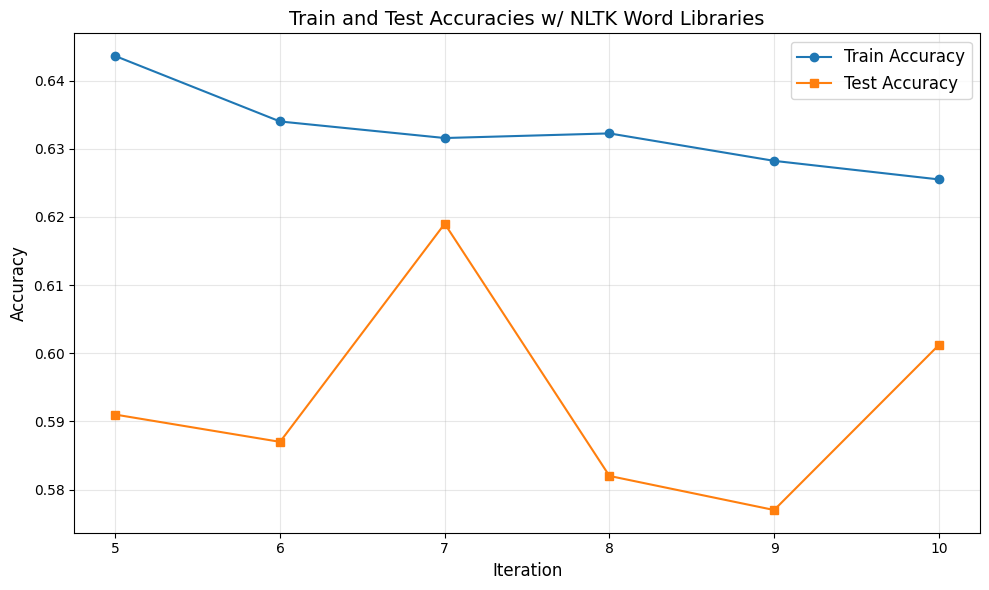

In [354]:
# Assuming `train_accuracies` and `test_accuracies` are populated from the iterations
train_sizes = ['5', '6', '7', '8', '9', '10']  # Number of iterations

plt.figure(figsize=(10, 6))

# Plot train accuracies
plt.plot(train_sizes, train_accuracies, label='Train Accuracy', marker='o')

# Plot test accuracies
plt.plot(train_sizes, test_accuracies, label='Test Accuracy', marker='s')

# Customize the plot
plt.title('Train and Test Accuracies w/ NLTK Word Libraries', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(train_sizes)  # Show each iteration on the x-axis
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

<h5 style="background: orange; color: black; padding: 5px">
    Next, we do a similar training/testing on the subset of the data, but this time with our model being a Random Forest.
</h5> 

In [355]:
# Initialize results
train_accuracies = []
test_accuracies = []

# Initial split: Use the first 5,000 rows as the initial training set
train_df = df_5k_copy.copy()

# Iteratively test and retrain
for i in range(0, len(test_set_copy), 1000):
    # Select the next 1,000 rows as the test set
    test_df = test_set_copy.iloc[i:i + 1000]
    
    # Run the regression function on the current train and test sets
    fit_regressors('random_forest', train_df, test_df)
    
    # Append the test set to the training set for the next iteration
    train_df = pd.concat([train_df, test_df], ignore_index=True)

# Display the accuracies after all iterations
print("Train Accuracies per Iteration:", train_accuracies)
print("Test Accuracies per Iteration:", test_accuracies)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'max_depth': 12, 'n_estimators': 115}
Best Score: -0.13365410870504257
Train Accuracy: 0.6316
Test Accuracy: 0.584
Negative Train Accuracy: 0.5551724137931034
Negative Test Accuracy: 0.458041958041958
Neutral Train Accuracy: 0.9537337662337663
Neutral Test Accuracy: 0.9151515151515152
Positive Train Accuracy: 0.0027624309392265192
Positive Test Accuracy: 0.0
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'max_depth': 12, 'n_estimators': 125}
Best Score: -0.13347438292102695
Train Accuracy: 0.6283333333333333
Test Accuracy: 0.59
Negative Train Accuracy: 0.5374423963133641
Negative Test Accuracy: 0.44947735191637633
Neutral Train Accuracy: 0.9574180466373775
Neutral Test Accuracy: 0.9389002036659878
Positive Train Accuracy: 0.0030651340996168583
Positive Test Accuracy: 0.0
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'max_depth': 12, 'n_estimators'

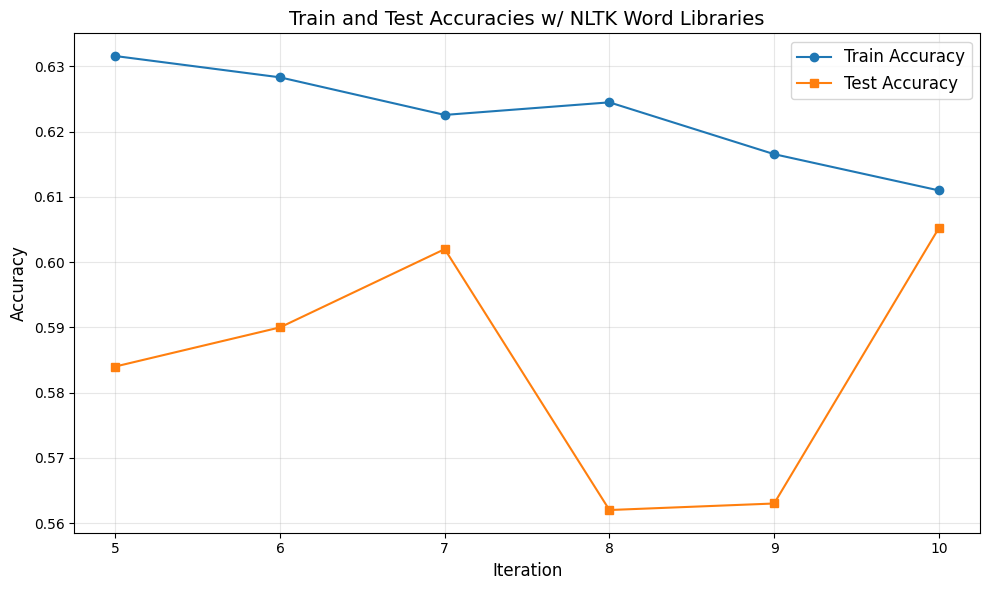

In [356]:
# Assuming `train_accuracies` and `test_accuracies` are populated from the iterations
train_sizes = ['5', '6', '7', '8', '9', '10']  # Number of iterations

plt.figure(figsize=(10, 6))

# Plot train accuracies
plt.plot(train_sizes, train_accuracies, label='Train Accuracy', marker='o')

# Plot test accuracies
plt.plot(train_sizes, test_accuracies, label='Test Accuracy', marker='s')

# Customize the plot
plt.title('Train and Test Accuracies w/ NLTK Word Libraries', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(train_sizes)  # Show each iteration on the x-axis
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

In [357]:
# Initialize results
train_accuracies = []
test_accuracies = []

# Initial split: Use the first 5,000 rows as the initial training set
train_df = df_5k_copy.copy()

# Iteratively test and retrain
for i in range(0, len(test_set_copy), 1000):
    # Select the next 1,000 rows as the test set
    test_df = test_set_copy.iloc[i:i + 1000]
    
    # Run the regression function on the current train and test sets
    fit_regressors('gradient_boosting', train_df, test_df)
    
    # Append the test set to the training set for the next iteration
    train_df = pd.concat([train_df, test_df], ignore_index=True)

# Display the accuracies after all iterations
print("Train Accuracies per Iteration:", train_accuracies)
print("Test Accuracies per Iteration:", test_accuracies)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Best Score: -0.1309034756437094
Train Accuracy: 0.6298
Test Accuracy: 0.579
Negative Train Accuracy: 0.5006896551724138
Negative Test Accuracy: 0.3951048951048951
Neutral Train Accuracy: 0.9622564935064936
Neutral Test Accuracy: 0.9292929292929293
Positive Train Accuracy: 0.04788213627992634
Positive Test Accuracy: 0.0273972602739726
Best Parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100}
Best Score: -0.12936747050295844
Train Accuracy: 0.6466666666666666
Test Accuracy: 0.601
Negative Train Accuracy: 0.538594470046083
Negative Test Accuracy: 0.445993031358885
Neutral Train Accuracy: 0.9580939506590064
Neutral Test Accuracy: 0.9348268839103869
Positive Train Accuracy: 0.0842911877394636
Positive Test Accuracy: 0.06306306306306306
Best Parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100}
Best Score: -0.1278815114411972
Train Accuracy: 0.6391428571428571
Test Accuracy: 0.62

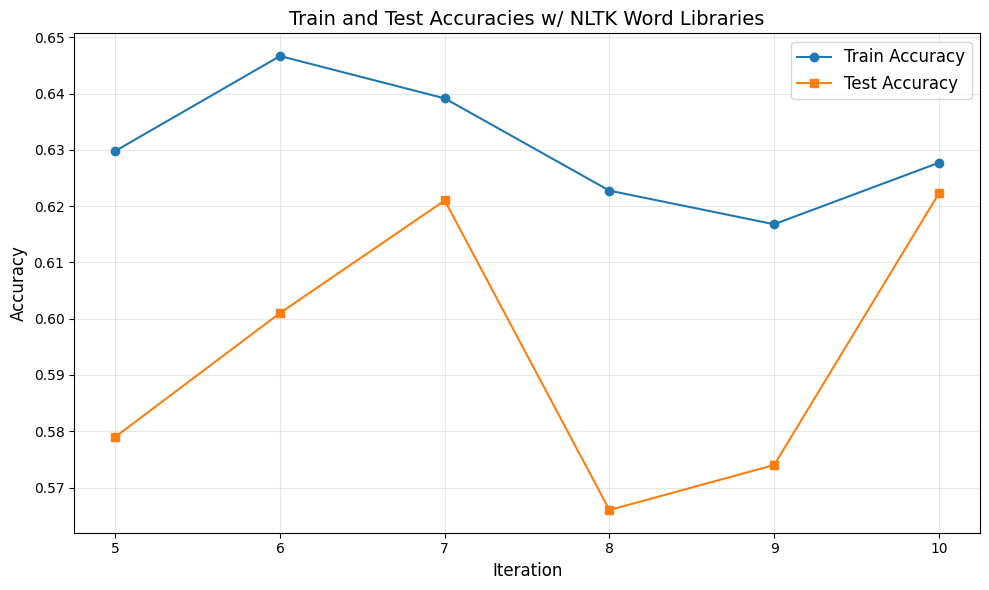

In [358]:
# Assuming `train_accuracies` and `test_accuracies` are populated from the iterations
train_sizes = ['5', '6', '7', '8', '9', '10']  # Number of iterations

plt.figure(figsize=(10, 6))

# Plot train accuracies
plt.plot(train_sizes, train_accuracies, label='Train Accuracy', marker='o')

# Plot test accuracies
plt.plot(train_sizes, test_accuracies, label='Test Accuracy', marker='s')

# Customize the plot
plt.title('Train and Test Accuracies w/ NLTK Word Libraries', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(train_sizes)  # Show each iteration on the x-axis
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

<div style="background: orange; color: black; padding: 5px">
    <h5>
        Now to give the classification of clickbait, balanced, and matter-of-fact a try. We will try the same method as feature_engineer3, which is simply to take the top 500 words and encode them as indicator features. 
    </h5>
</div>

In [359]:
def feature_engineer5(df):
    K = 500
    topK_words = dict(sorted(word_counts.items(), key = lambda x: x[1], reverse = True)[:K])
    for word in topK_words:
        df[word] = 0
    
    for idx, row in df.iterrows():
        for word in topK_words:
            if word in row['headline']:
                df.loc[idx, word] = 1
                
    df = pd.get_dummies(df, columns=['type', 'news_desk_category'])
    df.drop(['headline', 'sentiment_class', 'GPT_score', 'headline_no_stopwords'], axis=1, inplace=True)
    return df

In [360]:
df_5k_copy = df_5k.copy()
test_set_copy = test_set.copy()

df_5k_copy = feature_engineer5(df_5k_copy)
test_set_copy = feature_engineer5(test_set_copy)

df_5k_copy.head() 

/var/folders/04/2hwl1j9x5yl1hdpnd9k3jlqw0000gn/T/ipykernel_2861/3520707240.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word] = 0
/var/folders/04/2hwl1j9x5yl1hdpnd9k3jlqw0000gn/T/ipykernel_2861/3520707240.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word] = 0
/var/folders/04/2hwl1j9x5yl1hdpnd9k3jlqw0000gn/T/ipykernel_2861/3520707240.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

,year,GPT_class,paid,notice,deaths,new,us,corrections,reports,earnings,...,news_desk_category_special features,news_desk_category_sports,news_desk_category_technology,news_desk_category_theater,news_desk_category_times,news_desk_category_travel,news_desk_category_uncategorized,news_desk_category_weather/environment,news_desk_category_weekend,news_desk_category_world/international/foreign
0,0,balanced,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,0,balanced,0,0,0,0,1,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,0,clickbait,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,0,clickbait,0,0,0,0,1,0,0,0,...,False,True,False,False,False,False,False,False,False,False
4,0,clickbait,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False


In [361]:
regression_response = 'GPT_score'
classification_response = 'GPT_class'
predictors = [
    col for col in df_5k_copy.columns 
    if (col != regression_response and 
        col != classification_response)
]

X_train = df_5k_copy[predictors]
y_train = df_5k_copy[classification_response]

X_test = test_set_copy[predictors]
y_test = test_set_copy[classification_response]

ovr_logreg = LogisticRegression(max_iter=1000, random_state=109, multi_class='ovr')

ovrreg1 = ovr_logreg.fit(X_train, y_train)
y_pred = ovrreg1.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'The accuracy of one vs rest classifier model is {acc}')

The accuracy of one vs rest classifier model is 0.6380460153384462


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [362]:
rf_clf = RandomForestClassifier(random_state=109,
                                n_estimators=100)

param_grid = {
    'max_depth': range(10, 30)
}

grid_search = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv=5,                              
    n_jobs=-1,                         
    verbose=1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
 

Best Parameters: {'max_depth': 10}


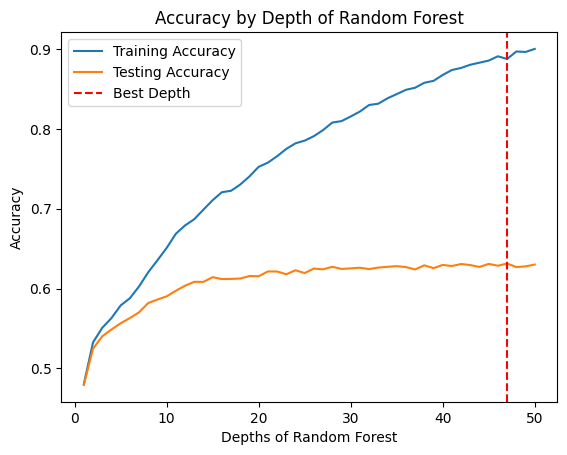

In [363]:
n_estimators = 100
training_accuracies = []
testing_accuracies = []

depths = range(1, 51)
for depth in depths:
    rf_clf = RandomForestClassifier(max_depth=depth, random_state=109, n_estimators=n_estimators)
    rf_clf.fit(X_train, y_train)
    
    y_train_pred = rf_clf.predict(X_train)
    y_test_pred = rf_clf.predict(X_test)
    
    training_acc = accuracy_score(y_train, y_train_pred)
    testing_acc = accuracy_score(y_test, y_test_pred)
    
    training_accuracies.append(training_acc)
    testing_accuracies.append(testing_acc)

best_rf_depth = depths[testing_accuracies.index(max(testing_accuracies))]

plt.plot(depths, training_accuracies, label='Training Accuracy')
plt.plot(depths, testing_accuracies, label='Testing Accuracy')
plt.axvline(best_rf_depth, color='red', linestyle='dashed', label='Best Depth')
plt.title('Accuracy by Depth of Random Forest')
plt.xlabel('Depths of Random Forest')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [364]:
print(f'The best depth for random forest was {best_rf_depth} with accuracy of {testing_accuracies[best_rf_depth]}')

The best depth for random forest was 47 with accuracy of 0.6268756252084028


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R

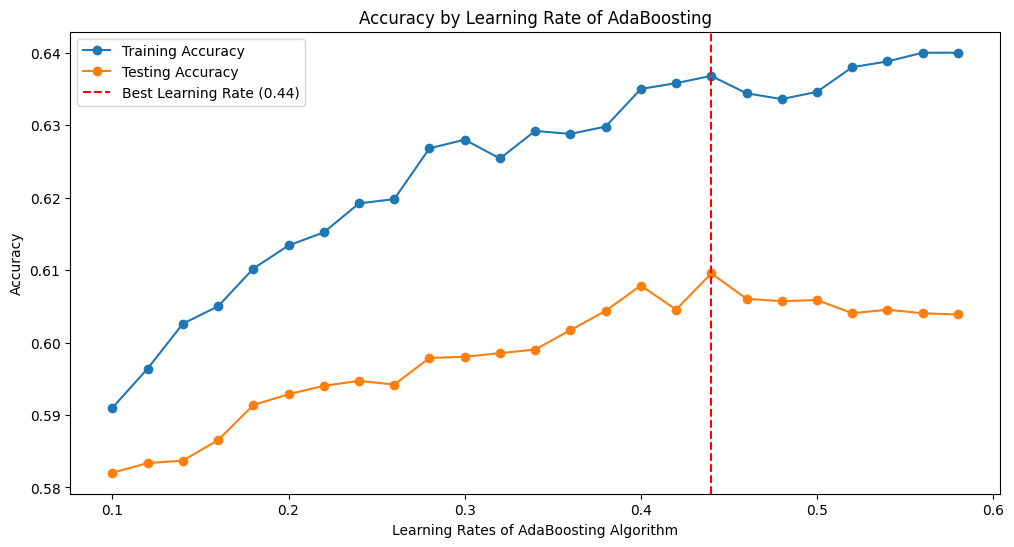

In [365]:
training_accs = []
testing_accs = []

learning_rates = np.arange(0.1, 0.6, 0.02)
for learning_rate in learning_rates:
    ada_clf = AdaBoostClassifier(n_estimators=100,
                                    learning_rate=learning_rate,
                                    random_state=109)
    
    ada_clf.fit(X_train, y_train)
    y_train_pred = ada_clf.predict(X_train)
    y_test_pred = ada_clf.predict(X_test)
    
    training_acc = accuracy_score(y_train, y_train_pred)
    testing_acc = accuracy_score(y_test, y_test_pred)
    
    training_accs.append(training_acc)
    testing_accs.append(testing_acc)

best_learning_rate = learning_rates[testing_accs.index(max(testing_accs))]

plt.figure(figsize=(12, 6))
plt.plot(learning_rates, training_accs, label='Training Accuracy', marker='o')
plt.plot(learning_rates, testing_accs, label='Testing Accuracy', marker='o')
plt.axvline(best_learning_rate, color='red', linestyle='dashed', label=f'Best Learning Rate ({best_learning_rate:.2f})')
plt.title('Accuracy by Learning Rate of AdaBoosting')
plt.xlabel('Learning Rates of AdaBoosting Algorithm')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [366]:
print(f'The best learning rate for AdaBoosting was {round(best_learning_rate, 2)}')
print(f'with accuracy of {max(testing_accs)}')

The best learning rate for AdaBoosting was 0.44
with accuracy of 0.6095365121707236


<div style="background: orange; color: black; padding: 5px">
    <h5>
        For this classification task of clickbait, balanced, or matter-of-fact, we see that logistic regression was the best performing model, with around 64 percent accuracy.
    </h5>
</div>
